In [1]:
pip install xgboost --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install category_encoders

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
# --- Fonction pour le projet --- #

def cross_valid(X_train, y_train, X_test, y_test, preprocessor):
    '''
    Fonction pour effectuer une cross-validation sur plusieurs mod√®les et √©valuer 
    leurs performances sur les donn√©es d'entra√Ænement et de test.
    '''
    
    # Liste des mod√®les √† tester
    liste = [
        DummyRegressor(strategy='mean'),   # Mod√®le de r√©f√©rence (baseline) : pr√©dit toujours la moyenne des cibles
        LinearRegression(),               # R√©gression lin√©aire simple sans r√©gularisation
        Ridge(),                          # R√©gression lin√©aire avec r√©gularisation L2 pour √©viter les coefficients trop grands
        Lasso(max_iter=20000, alpha = 100), # R√©gression lin√©aire avec r√©gularisation L1 pour r√©duire √† z√©ro les coefficients inutiles
        ElasticNet(max_iter=20000, alpha = 100), # Combine L1 et L2 pour un compromis entre parcimonie et limitation des coefficients
        RandomForestRegressor(random_state=42),  # For√™t al√©atoire, bas√©e sur des arbres de d√©cision, efficace pour les relations complexes
        KNeighborsRegressor(),            # K-Nearest Neighbors : utilise la proximit√© des donn√©es pour faire des pr√©dictions
        SVR(),                            # Support Vector Regressor : utilise des marges maximales pour la r√©gression
        XGBRegressor()                    # Extreme Gradient Boosting : m√©thode puissante d'ensemble bas√©e sur des arbres optimis√©s
    ]
    
    # Initialisation des listes pour stocker les r√©sultats des diff√©rentes m√©triques pendant la validation crois√©e
    RMSE = []       # Root Mean Squared Error : racine de l'erreur quadratique moyenne (CV)
    R2 = []         # Coefficient de d√©termination R¬≤ (CV)
    MAE = []        # Mean Absolute Error : erreur absolue moyenne (CV)
    MedAE = []      # Median Absolute Error : erreur absolue m√©diane (CV)
    FIT_TIME = []   # Temps moyen d'entra√Ænement pendant la cross-validation
    SCORE_TIME = [] # Temps moyen pour effectuer les pr√©dictions pendant la cross-validation
    
    # Initialisation des listes pour les performances sur le jeu de test
    TEST_RMSE = []  # Erreur quadratique moyenne (racine) sur le jeu de test
    TEST_R2 = []    # Coefficient de d√©termination R¬≤ sur le jeu de test
    TEST_MAE = []   # Erreur absolue moyenne sur le jeu de test
    TEST_MedAE = [] # Erreur absolue m√©diane sur le jeu de test

    # Boucle pour tester chaque mod√®le dans la liste
    for model in liste:
        # Cr√©ation d'un pipeline : 
        # - Applique d'abord le pr√©processeur aux donn√©es (standardisation/encodage)
        # - Ensuite, ajuste le mod√®le sp√©cifi√©
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Validation crois√©e (CV) pour √©valuer les performances sur plusieurs partitions des donn√©es d'entra√Ænement
        score = cross_validate(
            pipe,                         # Pipeline combinant pr√©processeur et mod√®le
            X_train, y_train,             # Donn√©es d'entra√Ænement
            cv=5,                         # Nombre de partitions (5-fold cross-validation)
            scoring=(                     # M√©triques d'√©valuation
                'neg_root_mean_squared_error',  # RMSE (retourn√© n√©gatif par sklearn, d'o√π le besoin d'inverser le signe)
                'r2',                          # Coefficient de d√©termination R¬≤
                'neg_mean_absolute_error',     # MAE (retourn√© n√©gatif par sklearn)
                'neg_median_absolute_error'    # MedAE (retourn√© n√©gatif par sklearn)
            ),
            return_train_score=False      # Ne pas inclure les scores sur le jeu d'entra√Ænement
        )
        
        # Moyenne des r√©sultats obtenus sur les 5 partitions (folds)
        rmse = score['test_neg_root_mean_squared_error'].mean()  # Moyenne des RMSE
        r2 = score['test_r2'].mean()                            # Moyenne des R¬≤
        mae = score['test_neg_mean_absolute_error'].mean()      # Moyenne des MAE
        medae = score['test_neg_median_absolute_error'].mean()  # Moyenne des MedAE
        fit_time = score['fit_time'].mean()                     # Temps moyen d'entra√Ænement
        score_time = score['score_time'].mean()                 # Temps moyen de pr√©diction

        # Entra√Æner le pipeline complet sur tout le jeu d'entra√Ænement
        pipe.fit(X_train, y_train)
        
        # Faire des pr√©dictions sur le jeu de test
        y_pred_test = pipe.predict(X_test)
        
        # Calcul des m√©triques sur le jeu de test
        test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE sur le test
        test_r2 = r2_score(y_test, y_pred_test)                            # R¬≤ sur le test
        test_mae = mean_absolute_error(y_test, y_pred_test)                # MAE sur le test
        test_medae = median_absolute_error(y_test, y_pred_test)            # MedAE sur le test

        # Stocker les r√©sultats dans les listes correspondantes
        RMSE.append(-rmse)  # RMSE, invers√© pour avoir une valeur positive
        R2.append(r2)       # Coefficient R¬≤
        MAE.append(-mae)    # MAE, invers√© pour avoir une valeur positive
        MedAE.append(-medae)# MedAE, invers√© pour avoir une valeur positive
        FIT_TIME.append(fit_time)       # Temps moyen d'entra√Ænement
        SCORE_TIME.append(score_time)   # Temps moyen de pr√©diction
        TEST_RMSE.append(test_rmse)     # RMSE sur le jeu de test
        TEST_R2.append(test_r2)         # R¬≤ sur le jeu de test
        TEST_MAE.append(test_mae)       # MAE sur le jeu de test
        TEST_MedAE.append(test_medae)   # MedAE sur le jeu de test
    
    # Cr√©ation d'un tableau (DataFrame pandas) pour rassembler tous les r√©sultats
    resultats = pd.DataFrame({
        'RMSE': RMSE,             # R√©sultats RMSE en CV
        'R2': R2,                 # R√©sultats R¬≤ en CV
        'MAE': MAE,               # R√©sultats MAE en CV
        'MedAE': MedAE,           # R√©sultats MedAE en CV
        'FIT_TIME': FIT_TIME,     # Temps moyen d'entra√Ænement en CV
        'SCORE_TIME': SCORE_TIME, # Temps moyen de pr√©diction en CV
        'TEST_RMSE': TEST_RMSE,   # RMSE sur le jeu de test
        'TEST_R2': TEST_R2,       # R¬≤ sur le jeu de test
        'TEST_MAE': TEST_MAE,     # MAE sur le jeu de test
        'TEST_MedAE': TEST_MedAE  # MedAE sur le jeu de test
    })
    
    # Nommer les lignes pour indiquer quel mod√®le correspond √† chaque ligne
    resultats.index = ['dum', 'lr', 'ridge', 'lasso', 'ElasticNet', 'RandomForest',
                       'KNR', 'SVR', 'XGBR']
    
    # Retourner le tableau des r√©sultats pour analyse
    return resultats

def metrics_one(grid):
    res = pd.DataFrame(grid['grid_search'].cv_results_).sort_values('rank_test_r2')
    print('Meilleurs param√®tres',grid['grid_search'].best_params_)
    print('Meilleur score RMSLE :',np.mean(res[res['rank_test_neg_mean_squared_log_error']==1]['mean_test_neg_mean_squared_log_error']))
    print('Meilleur score RMSE :',np.mean(res[res['rank_test_neg_root_mean_squared_error']==1]['mean_test_neg_root_mean_squared_error']))
    print('Meilleur score R2 :',grid['grid_search'].best_score_)
    print("R√©sultats des meilleurs param√®tres :\n")
    display(res.loc[res['params']==grid['grid_search'].best_params_])
    
    return res

def bar_plot_compare(df, colonnes, neg=False):
    ''' Affiche des bar plots pour chaque variable renseign√©e en les triant en ordre croissant. '''
    fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 6))  # Un seul rang de graphiques
    axes = axes.flatten()  # Transformer en liste pour faciliter l'it√©ration

    for i, col in enumerate(colonnes):
        sorted_df = df.sort_values(by=col, ascending=True)  # Trier les valeurs
        
        if neg:
            sns.barplot(x=sorted_df["Mod√®le"], y=-1 * sorted_df[col], ax=axes[i])
        else:
            sns.barplot(x=sorted_df["Mod√®le"], y=sorted_df[col], ax=axes[i])
        
        axes[i].set_title(col)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")  # Rotation pour lisibilit√©

    plt.tight_layout(pad=3)
    plt.show()

    
def metrics_pred(y_true, y_pred):
    '''Calcule les m√©triques'''
    rmsle = mean_squared_log_error(y_true= y_true, y_pred=y_pred)
    r2 =  r2_score(y_true= y_true, y_pred=y_pred)
    res = pd.DataFrame({'RMSLE': rmsle,'R2':r2},index=[0])
    return res

#Fonction pour √©valuer les performances
def metrics_pred(y_true, y_pred):
    res = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R¬≤": r2_score(y_true, y_pred)
    }
    return pd.DataFrame([res])  # Retourne un DataFrame pour affichage clair

#Fonction pour entra√Æner et tester un mod√®le
def test_model(model, model_name, X_train, y_train, X_test, y_test, preprocessor):
    """
    Fonction pour entra√Æner un mod√®le, pr√©dire et √©valuer les performances sur le jeu d'entra√Ænement et de test.
    """
    #Cr√©ation du pipeline avec preprocessing
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Appliquer le preprocessing
        ('model', model)  # Mod√®le ML
    ])

    #Entra√Ænement du mod√®le
    pipeline.fit(X_train, y_train)

    #Pr√©dictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    #√âvaluation des performances
    res_train = metrics_pred(y_train, y_train_pred)
    res_test = metrics_pred(y_test, y_test_pred)

    print(f"R√©sultats pour {model_name} :")
    print("Comparaison des performances sur le jeu d'entra√Ænement :")
    display(res_train)
    print("Comparaison des performances sur le jeu de test :")
    display(res_test)

    return res_train, res_test

def grid_search_cv(model, params, preprocessor):
    """
    Cr√©e un pipeline avec un pr√©processeur et une recherche d'hyperparam√®tres via GridSearchCV.

    Args:
        model: Mod√®le de r√©gression √† tester.
        params: Dictionnaire des hyperparam√®tres √† tester.

    Returns:
        Un pipeline entra√Ænable contenant le mod√®le optimis√©.
    """
    
    grid = Pipeline([
        ('preprocessor', preprocessor),  #Pr√©processor pass√© en param√®tre
        ('grid_search', GridSearchCV(
            TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),
            param_grid=params,
            cv=5,
            scoring=('neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error', 
                     'neg_median_absolute_error', 'neg_mean_squared_log_error'),
            return_train_score=True,
            refit='r2',
            n_jobs=-1
        ))
    ])
    
    return grid

def metric(grid, X_test, y_test):
    """
    Affiche et retourne les r√©sultats du GridSearchCV pour l'entra√Ænement et le test.

    Args:
        grid: Pipeline contenant le GridSearchCV.
        X_test: Donn√©es de test.
        y_test: Cibles de test.

    Returns:
        R√©sultats du GridSearchCV sous forme de DataFrame.
    """
    
    res = pd.DataFrame(grid['grid_search'].cv_results_).sort_values('rank_test_r2')
    
    print(" Meilleurs param√®tres :", grid['grid_search'].best_params_)
    print(" Meilleur score RMSE :", np.mean(res[res['rank_test_neg_root_mean_squared_error'] == 1]['mean_test_neg_root_mean_squared_error']))
    print(" Meilleur score R2 :", grid['grid_search'].best_score_)
    
    print("\n √âvaluation sur le jeu de test :")
    y_pred = grid.predict(X_test)
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    print(f" MAE (Test) : {mean_absolute_error(y_test, y_pred)}")
    print(f" RMSE (Test) : {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f" R¬≤ (Test) : {r2_score(y_test, y_pred)}")
    
    return res

# Pr√©diction et mod√©lisation pour la variable TotalGHGEmissions

## Sommaire 

    1. Pr√©paration des donn√©es
    2. Optimisation mod√®les
    3. Transformation
        3.1 Feature Engineering Manuel
        3.2 TargetEncoding
        3.3 Logarithmique
        3.4 R√©sultats
        3.5 Fine Tuning
    4. Features importance
    5. Impact Energy Score

In [5]:
#Import des diff√©rentes librairies poour le projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix, mean_squared_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from datetime import datetime
from category_encoders import TargetEncoder


import time

In [6]:
import warnings
#warnings.filterwarnings("always")  # Affiche tous les avertissements
warnings.filterwarnings('ignore')
#D√©sactivation des warnings de depreciations
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
#Import des donn√©es clean
data = pd.read_csv(r"C:\Users\Jonathan.Gourville\Downloads\data_clean.csv")

In [8]:
#Enregistrement du data dans une variable data_original
data_original = data.copy()

## 1. Pr√©paration des donn√©es

In [9]:
data.head()

OSEBuildingID Neighborhood  NumberofFloors  PropertyGFATotal  \
0              1     DOWNTOWN              12             88434   
1              2     DOWNTOWN              11            103566   
2              3     DOWNTOWN              41            956110   
3              5     DOWNTOWN              10             61320   
4              8     DOWNTOWN              18            175580   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  ...  \
0                        None                             0.0  ...   
1                  Restaurant                          4622.0  ...   
2                        None                             0.0  ...   
3                        None                             0.0  ...   
4               Swimming Pool                             0.0  ...   

   TotalGHGEmissions  BuildingAge  ElectricityUse  SteamUse  NaturalGasUse  \
0             249.98           89            True      True           True   
1             295.86           20            True     False           True   
2            2089.28           47            True      True           True   
3             286.43           90            True      True           True   
4             505.01           36            True     False           True   

   SteamUseMost  NaturalGasUseMost  ElectricityUseMost  ParkingRatioGFA  \
0         False              False                True         0.000000   
1         False               True               False         0.145453   
2         False              False                True         0.205748   
3         False              False                True         0.000000   
4         False               True               False         0.353115   

   MoreThan1Building  
0              False  
1              False  
2              False  
3              False  
4              False  

[5 rows x 22 columns]

In [10]:
data.shape

(1477, 22)

In [11]:
data.columns

Index(['OSEBuildingID', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')

In [12]:
data.dtypes

OSEBuildingID                        int64
Neighborhood                        object
NumberofFloors                       int64
PropertyGFATotal                     int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
BuildingAge                          int64
ElectricityUse                        bool
SteamUse                              bool
NaturalGasUse                         bool
SteamUseMost                          bool
NaturalGasUseMost                     bool
ElectricityUseMost                    bool
ParkingRatioGFA                    float64
MoreThan1Building                     bool
dtype: object

In [13]:
#S√©paration des features et de la target pour l'analyse
X = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis =1) #copie du data dans x, suppression des colonnes inutiles
y = data.copy()['TotalGHGEmissions'] #target

Cr√©ation d'un dataframe X contenant uniquement les variables explicatives (features), je supprimes les colonnes non n√©cassaires.

        OseBuildingId : cl√© unique, inutile pour l'entra√Ænement de don√©es
        SiteEnergyUse : l'autre target, cela √©vite de donn√©e au mod√©le des informations supp
        TotalGHGEmissions : La target principale
        ENERGYSTARScore : Variable corr√©le n√©gativement avec la target.

In [14]:
#Division du jeu d'entra√Ænement et de test, random state assure que la s√©paration des donn√©es restes identiques √† chaque √©x√©cution du code
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [15]:
#S√©parations des colonnes pour aider au traitement sp√©cifiques selon le type de donn√©es
quanti = X.select_dtypes(['int32','float64']).columns

quali = X.select_dtypes(['category','object','bool']).columns

In [16]:
#Normalisation des valeurs quantitatives avec un standardiseur
std_scaler = StandardScaler() #Centre les donn√©es(soustrait la moyenne) - R√©duit leur √©chelle(divise l'√©cart-type)
#Instancie un encodeur pour les variables quali
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False) # Transforme chaque variable en une colonne binaire (0 ou 1)
#preprocessor r√©cupere les transformation des colonnes, quanti est normalis√©, et quali est encod√©.
preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scaler,quanti),
    ('quali',ohe,quali)])

In [17]:
#Dimension du tableau retournant les donn√©es d'entrainement (features)
X_train.shape

(1181, 18)

In [18]:
#Dimension des donn√©es de test (features)
X_test.shape

(296, 18)

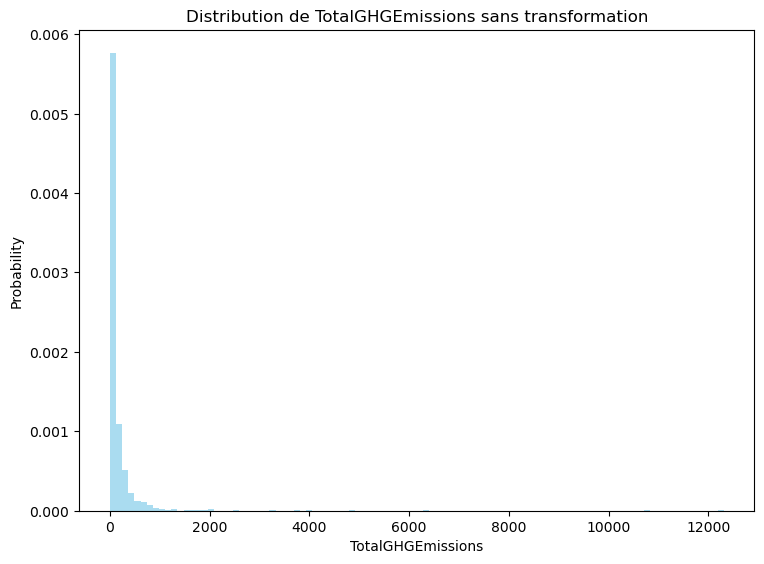

In [19]:
#Affichage de la distribution de la variable cible sans transformation
fig, ax0 = plt.subplots(figsize=(8, 6))

ax0.hist(y_train, bins=100, density=True, color='skyblue', alpha=0.7)
ax0.set_ylabel("Probability")
ax0.set_xlabel("TotalGHGEmissions")
ax0.set_title("Distribution de TotalGHGEmissions sans transformation")

plt.tight_layout(pad=2)
plt.show()

La variable suit une loi tr√®s asym√©trique (une longue queue √† droite ou gauche), une transformation logarithmique peut aider √† rendre la distribution plus proche de la normale. Cela peut am√©liorer la performance de certains mod√®les comme la r√©gression lin√©aire, qui est sensible √† la non-normalit√©.

In [20]:
#Application de la transformation logarithmique sur y_train
y_train_log = np.log(y_train + 1)  # Ajoute 1 pour √©viter log(0)

In [21]:
#J'applique aussi la transformation log sur y_test
y_test_log = np.log(y_test + 1)

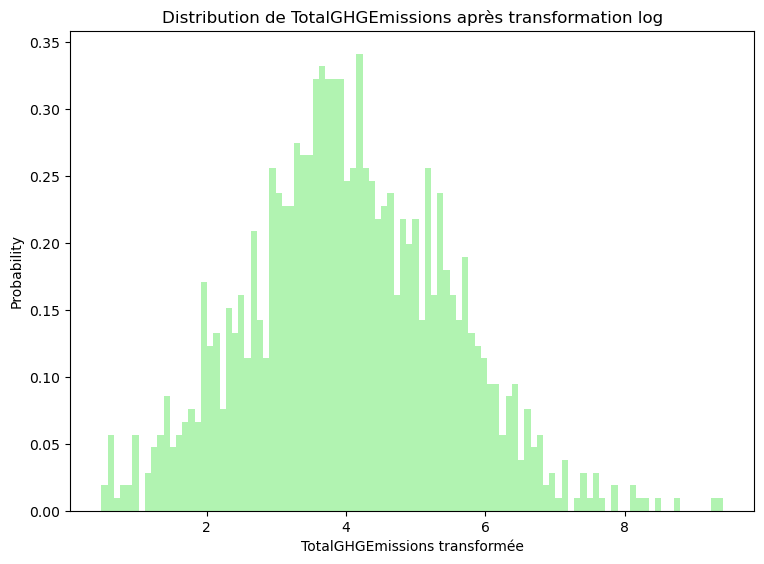

In [22]:
#Affichage de la distribution apr√®s transformation logarithmique
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.hist(y_train_log, bins=100, density=True, color='lightgreen', alpha=0.7)
ax1.set_ylabel("Probability")
ax1.set_xlabel("TotalGHGEmissions transform√©e")
ax1.set_title("Distribution de TotalGHGEmissions apr√®s transformation log")

plt.tight_layout(pad=2)
plt.show()

La cross-validation est une m√©thode cruciale pour √©valuer la performance d'un mod√®le de mani√®re robuste et fiable. Lorsque tu utilises plusieurs mod√®les dans une t√¢che de machine learning, faire une cross-validation pour chaque mod√®le pr√©sente plusieurs avantages.

Utilisation de cross validation sur plusieurs mod√®les qui permet de :

                1.√âvaluation fiable de la performance du mod√®le
                2.Comparaison des mod√®les
                3.Optimisation des hyperparam√®tres
                4.Utiliser toute la donn√©e disponible pour l'entra√Ænement
                5.Choisir entre des mod√®les simples et complexes
                6.D√©tection des biais

In [23]:
#Validation crois√©es sur plusieurs mod√©les de r√©gression (calcul de divers m√©trique sur chaque mod√©le)
resultats = cross_valid(X_train, y_train, X_test, y_test, preprocessor)

Metriques utilis√©s : 
        
            1. RMSE (Root Mean Squared Error) : Racine carr√©e de l'erreur quadratique moyenne(MSE), mesure la dispersion des erreurs entre les pr√©dictions et les valeurs r√©elles. PLUS RMSE est faible faible, MEILLEUR est le mod√®le. Proche de 0 -> pr√©dictions proche des valeurs r√©elles
            2. R¬≤ (Coefficient de d√©termination) : mesure de la proportion de variance des donn√©es expliqu√©e par le mod√®le. =1 explique toute la variance des donn√©es, =0 mod√©le ne fait pas mieux que pr√©dire la moyenne de la cible, <0 moins performant qu'un mod√©le qui pr√©dit la moyenne
            3.MAE (Mean Absolute Error) : mesure l'erreur absolue moyenne entre les valeurs pr√©dites et les valeurs r√©elles. Calcul√© comme la moyenne des valeurs absolues des erreurs. Proche de 0 = pr√©dictions proches des valeurs r√©elles, √©lev√©e = erreurs sont importantes en moyenne.
            4. MedAE (Median Absolute Error) : messure de l'erreur m√©diane absolue. Il est contraire √† MAE, il mesure la m√©diane des erreurs absolues, donc plus robuste aux valeurs extr√™mes d'un mod√©le. Valeur faible = erreurs petites, m√™me si certaines sont grandes. Valeur √©lev√©e = certaines erreurs sont importantes et influencent le mod√®le. Proche de 0.
            5. FIT_TIME (Temps d'entra√Ænement) : Temps que prend le mod√©le pour s'entrainer sur les donn√©es d'entra√Ænement, cela d√©pend de la complexit√©, du nombre de donn√©es, de la puissance de calcul dispo: valeur faible √† mod√©r√©e : un mod√©le comme r√©gression lin√©aire aura un temps faible mais XGBoost ou r√©seau de neurones plus long, √©lev√© : mod√©le complexe ou grand jeu de donn√©es
            6.SCORE_TIME (Temps de pr√©diction) : mesure le temps que prend le mod√®le pour faire des pr√©dictions sur les donn√©es de test.  Regr√©ssion lin√©aire temps faible, RandomForest temps plus long. Trop √©lev√©e rend le mod√©le impratique en prod.
            
Les r√©sultats concernent le jeu d'entra√Ænement et de test.             

In [24]:
resultats

RMSE            R2           MAE       MedAE  FIT_TIME  \
dum           5.253284e+02 -7.499186e-03  2.015257e+02  142.259585  0.013441   
lr            6.106470e+12 -7.067893e+20  9.316108e+11   93.823375  0.024711   
ridge         3.914414e+02  3.416396e-01  1.733444e+02   94.248786  0.012313   
lasso         4.594879e+02  2.577212e-01  1.595653e+02   65.657279  0.010309   
ElasticNet    5.209641e+02  1.341972e-02  1.984059e+02  139.517483  0.009120   
RandomForest  4.135467e+02  2.413460e-01  1.092873e+02   26.589970  0.605387   
KNR           4.233611e+02  3.994330e-01  1.202726e+02   30.098400  0.008420   
SVR           5.321407e+02 -3.858831e-02  1.461759e+02   29.379103  0.063462   
XGBR          3.338615e+02  6.109246e-01  1.028495e+02   28.679858  0.114531   

              SCORE_TIME     TEST_RMSE       TEST_R2      TEST_MAE  TEST_MedAE  
dum             0.005988  1.113653e+03 -4.231988e-04  2.459440e+02  148.065216  
lr              0.005598  9.601055e+12 -7.435707e+19  9.975373e+11   74.890000  
ridge           0.005404  1.017451e+03  1.649525e-01  1.948596e+02   80.731575  
lasso           0.005115  1.021749e+03  1.578816e-01  1.938515e+02   64.985613  
ElasticNet      0.005180  1.108467e+03  8.872061e-03  2.431223e+02  145.742548  
RandomForest    0.011536  6.317743e+02  6.780353e-01  1.192154e+02   23.553550  
KNR             0.010600  1.022198e+03  1.571414e-01  1.543241e+02   23.260000  
SVR             0.035877  1.118005e+03 -8.257478e-03  1.736543e+02   25.577098  
XGBR            0.008954  7.265023e+02  5.742464e-01  1.142627e+02   24.850764

In [25]:
#On test sur les donn√©es log.
resultats_log = cross_valid(X_train, y_train_log, X_test, y_test_log, preprocessor)

In [26]:
resultats_log

RMSE            R2           MAE     MedAE  FIT_TIME  \
dum           1.429473e+00 -3.988719e-03  1.134667e+00  0.950801  0.015259   
lr            1.605942e+10 -1.568873e+20  2.564532e+09  0.583286  0.017782   
ridge         8.814510e-01  6.173972e-01  6.793887e-01  0.556893  0.010006   
lasso         1.429473e+00 -3.988719e-03  1.134667e+00  0.950801  0.009813   
ElasticNet    1.429473e+00 -3.988719e-03  1.134667e+00  0.950801  0.008708   
RandomForest  7.663453e-01  7.115013e-01  5.849249e-01  0.440960  0.495280   
KNR           8.897643e-01  6.103588e-01  6.864904e-01  0.551667  0.007402   
SVR           7.564869e-01  7.187764e-01  5.842337e-01  0.465741  0.061061   
XGBR          7.553389e-01  7.194803e-01  5.763892e-01  0.442575  0.074907   

              SCORE_TIME     TEST_RMSE       TEST_R2      TEST_MAE  TEST_MedAE  
dum             0.010232  1.525240e+00 -2.997054e-02  1.192649e+00    0.978966  
lr              0.006711  6.040431e+10 -1.615416e+21  6.275930e+09    0.551449  
ridge           0.005091  9.534834e-01  5.974917e-01  6.820557e-01    0.556328  
lasso           0.004201  1.525240e+00 -2.997054e-02  1.192649e+00    0.978966  
ElasticNet      0.004182  1.525240e+00 -2.997054e-02  1.192649e+00    0.978966  
RandomForest    0.012900  7.909131e-01  7.230469e-01  5.769760e-01    0.452717  
KNR             0.009247  9.221932e-01  6.234762e-01  7.025428e-01    0.566200  
SVR             0.031444  8.407961e-01  6.870103e-01  5.906684e-01    0.479109  
XGBR            0.007503  8.256099e-01  6.982145e-01  5.728761e-01    0.415539

**Interpr√©tation des r√©sultats :**

         1. DUM : Aucun pouvoir pr√©dictif, pr√©diction constante
         2. Linear Regression : le mod√®le n'est pas du tout adapt√© pour les donn√©es et √©choue
         3. Ridge Regression : ce mod√®le est plus robuste que la RL et montre de meilleures performances mais < XGBR ou RF                4. Lasso Regression : mod√®les ne semblent pas bien performer pour ces donn√©es sp√©cifiques
         5. ElasticNet : Mod√®les ne semblent pas bien performer pour ces donn√©es sp√©cifiques
         6. RandomForest : Bonnes performances, surpassant de nombreux autres mod√®les (√† l'exception de XGBoost)
         7. KNR : ce mod√®le semble moins performant que Random Forest ou XGBoost
         8. SVR : Tr√®s bon mod√©le, mais prend du temps pour faire des pr√©dictions
         9. XGBR : Meilleur compromis RMSE et R¬≤, mod√©le performant, robuste et rapide

## 2. Optimisation des mod√®les

In [27]:
#Liste des mod√®les √† tester
models = {
    "DummyRegressor": DummyRegressor(),
    "LinearRegression": LinearRegression(fit_intercept=True, n_jobs=-1, positive=False),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42)
}

#Stockage des r√©sultats
results_train = {}
results_test = {}

#Boucle pour tester chaque mod√®le
for model_name, model in models.items():
    train_res, test_res = test_model(model, model_name, X_train, y_train, X_test, y_test, preprocessor)
    results_train[model_name] = train_res
    results_test[model_name] = test_res

R√©sultats pour DummyRegressor :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE            MSE        RMSE   R¬≤
0  201.679711  374475.975448  611.944422  0.0

Comparaison des performances sur le jeu de test :


MAE           MSE         RMSE        R¬≤
0  245.94403  1.240222e+06  1113.652572 -0.000423

R√©sultats pour LinearRegression :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE           MSE        RMSE       R¬≤
0  134.417439  97633.343924  312.463348  0.73928

Comparaison des performances sur le jeu de test :


MAE           MSE          RMSE            R¬≤
0  9.975373e+11  9.218026e+25  9.601055e+12 -7.435707e+19

R√©sultats pour Ridge :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE            MSE        RMSE        R¬≤
0  144.333358  101935.367474  319.273186  0.727792

Comparaison des performances sur le jeu de test :


MAE           MSE         RMSE        R¬≤
0  194.859589  1.035206e+06  1017.450874  0.164952

R√©sultats pour Lasso :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE            MSE        RMSE        R¬≤
0  139.034824  105925.709971  325.462302  0.717136

Comparaison des performances sur le jeu de test :


MAE           MSE         RMSE        R¬≤
0  178.76903  1.020468e+06  1010.182148  0.176841

R√©sultats pour ElasticNet :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE            MSE        RMSE        R¬≤
0  147.937011  233516.820281  483.235781  0.376417

Comparaison des performances sur le jeu de test :


MAE           MSE         RMSE        R¬≤
0  181.222561  1.055409e+06  1027.331052  0.148656

R√©sultats pour KNeighborsRegressor :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE            MSE        RMSE        R¬≤
0  96.281272  138389.739577  372.007714  0.630444

Comparaison des performances sur le jeu de test :


MAE           MSE         RMSE        R¬≤
0  154.324074  1.044890e+06  1022.198451  0.157141

R√©sultats pour SVR :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE            MSE        RMSE        R¬≤
0  144.209352  381095.793939  617.329567 -0.017678

Comparaison des performances sur le jeu de test :


MAE           MSE         RMSE        R¬≤
0  173.654323  1.249934e+06  1118.004556 -0.008257

R√©sultats pour RandomForestRegressor :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE           MSE        RMSE        R¬≤
0  36.676613  16996.112369  130.369139  0.954614

Comparaison des performances sur le jeu de test :


MAE            MSE       RMSE        R¬≤
0  119.21543  399138.804317  631.77433  0.678035

R√©sultats pour XGBRegressor :
Comparaison des performances sur le jeu d'entra√Ænement :


MAE         MSE       RMSE        R¬≤
0  20.586291  968.841675  31.126222  0.997413

Comparaison des performances sur le jeu de test :


MAE            MSE        RMSE        R¬≤
0  114.262733  527805.590911  726.502299  0.574246

In [28]:
#Cr√©er une liste des r√©sultats en DataFrame
df_train_results = pd.concat(results_train).reset_index(level=1, drop=True).reset_index()
df_test_results = pd.concat(results_test).reset_index(level=1, drop=True).reset_index()

#Renommer la colonne contenant le nom du mod√®le
df_train_results = df_train_results.rename(columns={'index': 'Mod√®le'})
df_test_results = df_test_results.rename(columns={'index': 'Mod√®le'})

#Ajouter une colonne pour identifier l'ensemble de donn√©es
df_train_results["Dataset"] = "Train"
df_test_results["Dataset"] = "Test"

#Fusionner les r√©sultats
df_results_1 = pd.concat([df_train_results, df_test_results])

#Afficher le DataFrame final
df_results_1

Mod√®le           MAE           MSE          RMSE  \
0         DummyRegressor  2.016797e+02  3.744760e+05  6.119444e+02   
1       LinearRegression  1.344174e+02  9.763334e+04  3.124633e+02   
2                  Ridge  1.443334e+02  1.019354e+05  3.192732e+02   
3                  Lasso  1.390348e+02  1.059257e+05  3.254623e+02   
4             ElasticNet  1.479370e+02  2.335168e+05  4.832358e+02   
5    KNeighborsRegressor  9.628127e+01  1.383897e+05  3.720077e+02   
6                    SVR  1.442094e+02  3.810958e+05  6.173296e+02   
7  RandomForestRegressor  3.667661e+01  1.699611e+04  1.303691e+02   
8           XGBRegressor  2.058629e+01  9.688417e+02  3.112622e+01   
0         DummyRegressor  2.459440e+02  1.240222e+06  1.113653e+03   
1       LinearRegression  9.975373e+11  9.218026e+25  9.601055e+12   
2                  Ridge  1.948596e+02  1.035206e+06  1.017451e+03   
3                  Lasso  1.787690e+02  1.020468e+06  1.010182e+03   
4             ElasticNet  1.812226e+02  1.055409e+06  1.027331e+03   
5    KNeighborsRegressor  1.543241e+02  1.044890e+06  1.022198e+03   
6                    SVR  1.736543e+02  1.249934e+06  1.118005e+03   
7  RandomForestRegressor  1.192154e+02  3.991388e+05  6.317743e+02   
8           XGBRegressor  1.142627e+02  5.278056e+05  7.265023e+02   

             R¬≤ Dataset  
0  0.000000e+00   Train  
1  7.392801e-01   Train  
2  7.277920e-01   Train  
3  7.171362e-01   Train  
4  3.764171e-01   Train  
5  6.304443e-01   Train  
6 -1.767755e-02   Train  
7  9.546136e-01   Train  
8  9.974128e-01   Train  
0 -4.231988e-04    Test  
1 -7.435707e+19    Test  
2  1.649525e-01    Test  
3  1.768411e-01    Test  
4  1.486559e-01    Test  
5  1.571414e-01    Test  
6 -8.257478e-03    Test  
7  6.780353e-01    Test  
8  5.742464e-01    Test

Train set :

- DummyRegressor(MAE : 216.10, RMSE : 802.61 et R¬≤ : 0.000) : indique un mod√®le qui sert uniquement de r√©f√©rence.
- LineaRegression(MAE : 167.83, RMSE : 409.71 et R¬≤ : 0.739) : performance mod√©r√©e, bien ajust√© au mod√®le d'entra√Ænement
- Ridge(MAE : 174.42, RMSE : 416.66 et R¬≤ : 0.730) : r√©sultat un peu similaire √† la LineaRegression
- Lasso(MAE : 167.97, RMSE : 423.51 et R¬≤ : 0.722) : un peu moins performant que la LineaRegression
- ElasticNet(MAE : 168.54, RMSE : 604.50 et R¬≤ : 0.433) : mod√®le un peu moins performant que Ridge et Lasso
- KNR(MAE : 105.32, RMSE : 548.67 et R¬≤ : 0.533) : mod√®le fonctionne bien sur les donn√©es d'entra√Ænement, mais n'excelle pas autant que les mod√®les comme Random Forest ou XGBoost.
- SVR(MAE : 151.47, RMSE : 807.67 et R¬≤ : -0.0126) : ce mod√®le a des performances tr√®s m√©diocres, avec un R¬≤ proche de z√©ro, indiquant qu'il n'explique pas la variance des donn√©es
- RandomForest(MAE : 36.68, RMSE : 164.63 et R¬≤ : 0.957) :  excellent mod√®le pour les donn√©es d'entra√Ænement, avec un faible MAE et RMSE, et un R¬≤ tr√®s √©lev√©
- XGBRegressor(MAE : 21.89, RMSE : 44.59 et R¬≤ : 0.997) : mod√®le donne des r√©sultats exceptionnels sur le jeu d'entra√Ænement, avec un MAE et un RMSE tr√®s faibles, et un R¬≤ tr√®s proche de 1

Test set : 

- DummyRegressor : MAE est toujours √©lev√© (206.18) et le R¬≤ reste n√©gatif (-0.0003), indiquant une tr√®s mauvaise performance sur les donn√©es de test
- LineaRegression : r√©sultats catastrophiques : MAE tr√®s √©lev√© (9.29e+11) et un R¬≤ extr√™mement faible (-1.928e+20), montrant un sur-apprentissage complet (overfitting)
- Ridge : MAE : 187.50 et R¬≤ : -0.0222, l√©g√®rement plus bas que la r√©gression lin√©aire sur le jeu de test, mais toujours mauvais
- Lasso : MAE : 169.84 et R¬≤ : -0.0151, tr√®s similaire √† Ridge, avec des performances m√©diocres sur le jeu de test
- ElasticNet : MAE : 173.25 et R¬≤ : 0.006, avec une l√©g√®re am√©lioration par rapport √† Ridge et Lasso
- KNR : MAE : 140.11 et R¬≤ : -0.1085, montre un certain sur-apprentissage et de mauvaises performances
- SVR : MAE : 145.35 et R¬≤ : -0.0434, encore une fois, ce mod√®le a des r√©sultats m√©diocres sur les donn√©es de test
- RandomForest : MAE : 124.27 et R¬≤ : -0.477, une chute importante par rapport √† la performance sur les donn√©es d'entra√Ænement. Cela indique que le mod√®le pourrait √™tre sur-ajust√© aux donn√©es d'entra√Ænement, ne g√©n√©ralisant pas bien aux donn√©es de test
- XGBRegressor : MAE : 127.05 et R¬≤ : -1.177, ce mod√®le montre une d√©gradation significative des performances sur le jeu de test par rapport √† l'entra√Ænement, avec un R¬≤ tr√®s n√©gatif. Cela pourrait √™tre d√ª √† un sur-apprentissage ou √† un ajustement inad√©quat des hyperparam√®tres

Conlusion : 

- XGBRegressor et RandomForestRegressor semblent √™tre les mod√®les les plus performants sur les donn√©es d'entra√Ænement, mais ils ont une d√©t√©rioration significative sur le jeu de test. Cela indique un probl√®me de sur-apprentissage (overfitting)
- Linear Regression, Ridge, et Lasso sont plus robustes sur les donn√©es de test mais semblent sous-performer sur l'entra√Ænement. Cependant, ces mod√®les pr√©sentent un meilleur √©quilibre entre entra√Ænement et test, ce qui sugg√®re qu'ils sont plus simples et moins sensibles au sur-apprentissage.
- Les mod√®les comme SVR, ElasticNet, et KNeighborsRegressor semblent tous souffrir de mauvaises performances tant sur l'entra√Ænement que sur le test.

In [29]:
def perform_grid_search_cv(grid_search_cv, metrics, X_train, y_train, X_test, y_test, preprocessor):
    """
    Effectue une recherche d'hyperparam√®tres pour plusieurs mod√®les en utilisant GridSearchCV.
    
    Args:
        grid_search_cv: Fonction qui cr√©e et retourne un pipeline avec GridSearchCV.
        metrics: Fonction qui √©value les performances du mod√®le
        X_train, y_train: Donn√©es d'entrainement.
        X_test, y_test: Donn√©es de test
        preprocessor : Pr√©processeur (Pipeline ou ColumnTransformer)
        
    Returns: 
        DataFrame avec les meilleurs param√®tres et scores des mod√®les.
    """
    
    #Dictionnaire des mod√®les et leurs hyperparam√®tres
    grid_models = {
        "DummyRegressor": (DummyRegressor(), {'regressor__strategy': ['mean', 'median']}),
        "LinearRegression": (LinearRegression(), {"regressor__fit_intercept": [True, False], "regressor__positive": [True, False]}),
        "Ridge": (Ridge(), {'regressor__alpha': np.arange(0, 2000, 200)}),
        "Lasso": (Lasso(), {'regressor__alpha': np.arange(0.001, 1.0, 0.05)}), #test sur 20 valeurs max
        "ElasticNet": (ElasticNet(), {'regressor__alpha': np.arange(0.01, 1.0, 0.05), 'regressor__l1_ratio': np.arange(0.2, 1.0, 0.3)}),
        "KNeighborsRegressor": (KNeighborsRegressor(), {"regressor__n_neighbors": [3,5,7], "regressor__weights": ['uniform', 'distance'], "regressor__leaf_size": [10, 30], "regressor__p": [1,2]}),
        "SVR": (SVR(), {'regressor__kernel': ['rbf'], 'regressor__gamma' : ['scale', 1e-3], 'regressor__C': [1, 10], 'regressor__epsilon' : [0.1]}),
        "RandomForestRegressor": (RandomForestRegressor(random_state=42), {'regressor__n_estimators' : [100,500,1000], 'regressor__max_depth': [3,5, None]}),
        "XGBRegressor": (XGBRegressor(random_state=42), {'regressor__gamma': [0, 0.01], 'regressor__learning_rate' : [0.01, 0.1], 'regressor__max_depth': [3,6], 'regressor__n_estimators': [100, 300]})
    }
    
    grid_results = []
    
    for model_name, (model, params) in grid_models.items():
        print(f"GridSearch pour {model_name}...")
        
        grid_model = grid_search_cv(model, params, preprocessor)
        grid_model.fit(X_train, y_train)
        
        res = metrics(grid_model, X_test, y_test)
        
        best_params = grid_model['grid_search'].best_params_
        best_score_r2 = grid_model['grid_search'].best_score_
        best_score_rmse = np.mean(res[res['rank_test_neg_root_mean_squared_error'] == 1]['mean_test_neg_root_mean_squared_error'])
        
        grid_results.append({
            "Mod√®le": model_name,
            "Meilleurs Param√®tres": best_params,
            "Meilleur R¬≤ (CV)": best_score_r2,
            "Meilleur RMSE (CV)": best_score_rmse
        })
    
    df_grid_results = pd.DataFrame(grid_results)
    display(df_grid_results)
    
    return df_grid_results

In [30]:
#Remplacer les valeurs inf √† 0 par une m√©diane
y_train[y_train <= 0] = y_train.median()

In [31]:
#Ex√©cuter la fonction
df_results = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

#Affichage du DataFrame des r√©sultats
print(df_results)

GridSearch pour DummyRegressor...
 Meilleurs param√®tres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -539.5034368133232
 Meilleur score R2 : -0.07720658003510343

 √âvaluation sur le jeu de test :
 MAE (Test) : 186.02013501475005
 RMSE (Test) : 1123.1405826694659
 R¬≤ (Test) : -0.017542470695500745
GridSearch pour LinearRegression...
 Meilleurs param√®tres : {'regressor__fit_intercept': False, 'regressor__positive': True}
 Meilleur score RMSE : -9937.688565954611
 Meilleur score R2 : -314.3249018911253

 √âvaluation sur le jeu de test :
 MAE (Test) : 216.62111988879104
 RMSE (Test) : 1585.255947863917
 R¬≤ (Test) : -1.0271369400983126
GridSearch pour Ridge...
 Meilleurs param√®tres : {'regressor__alpha': 1200}
 Meilleur score RMSE : -487.49700879391264
 Meilleur score R2 : 0.058597706078860876

 √âvaluation sur le jeu de test :
 MAE (Test) : 150.67592907901047
 RMSE (Test) : 773.8562525983283
 R¬≤ (Test) : 0.5169357510526039
GridSearch pour Lasso...
 Meilleurs param√®tres 

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1200}   
3                  Lasso          {'regressor__alpha': 0.30100000000000005}   
4             ElasticNet  {'regressor__alpha': 0.6100000000000001, 'regr...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0, 'regressor__learning_r...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1       -314.324902        -9937.688566  
2          0.058598         -487.497009  
3          0.090741         -482.554167  
4          0.122837         -458.996920  
5          0.383622         -424.733770  
6          0.503754         -397.489258  
7          0.538905         -386.187030  
8          0.602937         -341.103811

                  Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1200}   
3                  Lasso          {'regressor__alpha': 0.30100000000000005}   
4             ElasticNet  {'regressor__alpha': 0.6100000000000001, 'regr...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0, 'regressor__learning_r...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1       -314.324902        -9937.688566  
2          0.058598         -487.497009  
3          0.090741         -482.55416

### Comparaison des r√©sultats 

In [32]:
df_results_1

Mod√®le           MAE           MSE          RMSE  \
0         DummyRegressor  2.016797e+02  3.744760e+05  6.119444e+02   
1       LinearRegression  1.344174e+02  9.763334e+04  3.124633e+02   
2                  Ridge  1.443334e+02  1.019354e+05  3.192732e+02   
3                  Lasso  1.390348e+02  1.059257e+05  3.254623e+02   
4             ElasticNet  1.479370e+02  2.335168e+05  4.832358e+02   
5    KNeighborsRegressor  9.628127e+01  1.383897e+05  3.720077e+02   
6                    SVR  1.442094e+02  3.810958e+05  6.173296e+02   
7  RandomForestRegressor  3.667661e+01  1.699611e+04  1.303691e+02   
8           XGBRegressor  2.058629e+01  9.688417e+02  3.112622e+01   
0         DummyRegressor  2.459440e+02  1.240222e+06  1.113653e+03   
1       LinearRegression  9.975373e+11  9.218026e+25  9.601055e+12   
2                  Ridge  1.948596e+02  1.035206e+06  1.017451e+03   
3                  Lasso  1.787690e+02  1.020468e+06  1.010182e+03   
4             ElasticNet  1.812226e+02  1.055409e+06  1.027331e+03   
5    KNeighborsRegressor  1.543241e+02  1.044890e+06  1.022198e+03   
6                    SVR  1.736543e+02  1.249934e+06  1.118005e+03   
7  RandomForestRegressor  1.192154e+02  3.991388e+05  6.317743e+02   
8           XGBRegressor  1.142627e+02  5.278056e+05  7.265023e+02   

             R¬≤ Dataset  
0  0.000000e+00   Train  
1  7.392801e-01   Train  
2  7.277920e-01   Train  
3  7.171362e-01   Train  
4  3.764171e-01   Train  
5  6.304443e-01   Train  
6 -1.767755e-02   Train  
7  9.546136e-01   Train  
8  9.974128e-01   Train  
0 -4.231988e-04    Test  
1 -7.435707e+19    Test  
2  1.649525e-01    Test  
3  1.768411e-01    Test  
4  1.486559e-01    Test  
5  1.571414e-01    Test  
6 -8.257478e-03    Test  
7  6.780353e-01    Test  
8  5.742464e-01    Test

In [33]:
df_results

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1200}   
3                  Lasso          {'regressor__alpha': 0.30100000000000005}   
4             ElasticNet  {'regressor__alpha': 0.6100000000000001, 'regr...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0, 'regressor__learning_r...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1       -314.324902        -9937.688566  
2          0.058598         -487.497009  
3          0.090741         -482.554167  
4          0.122837         -458.996920  
5          0.383622         -424.733770  
6          0.503754         -397.489258  
7          0.538905         -386.187030  
8          0.602937         -341.103811

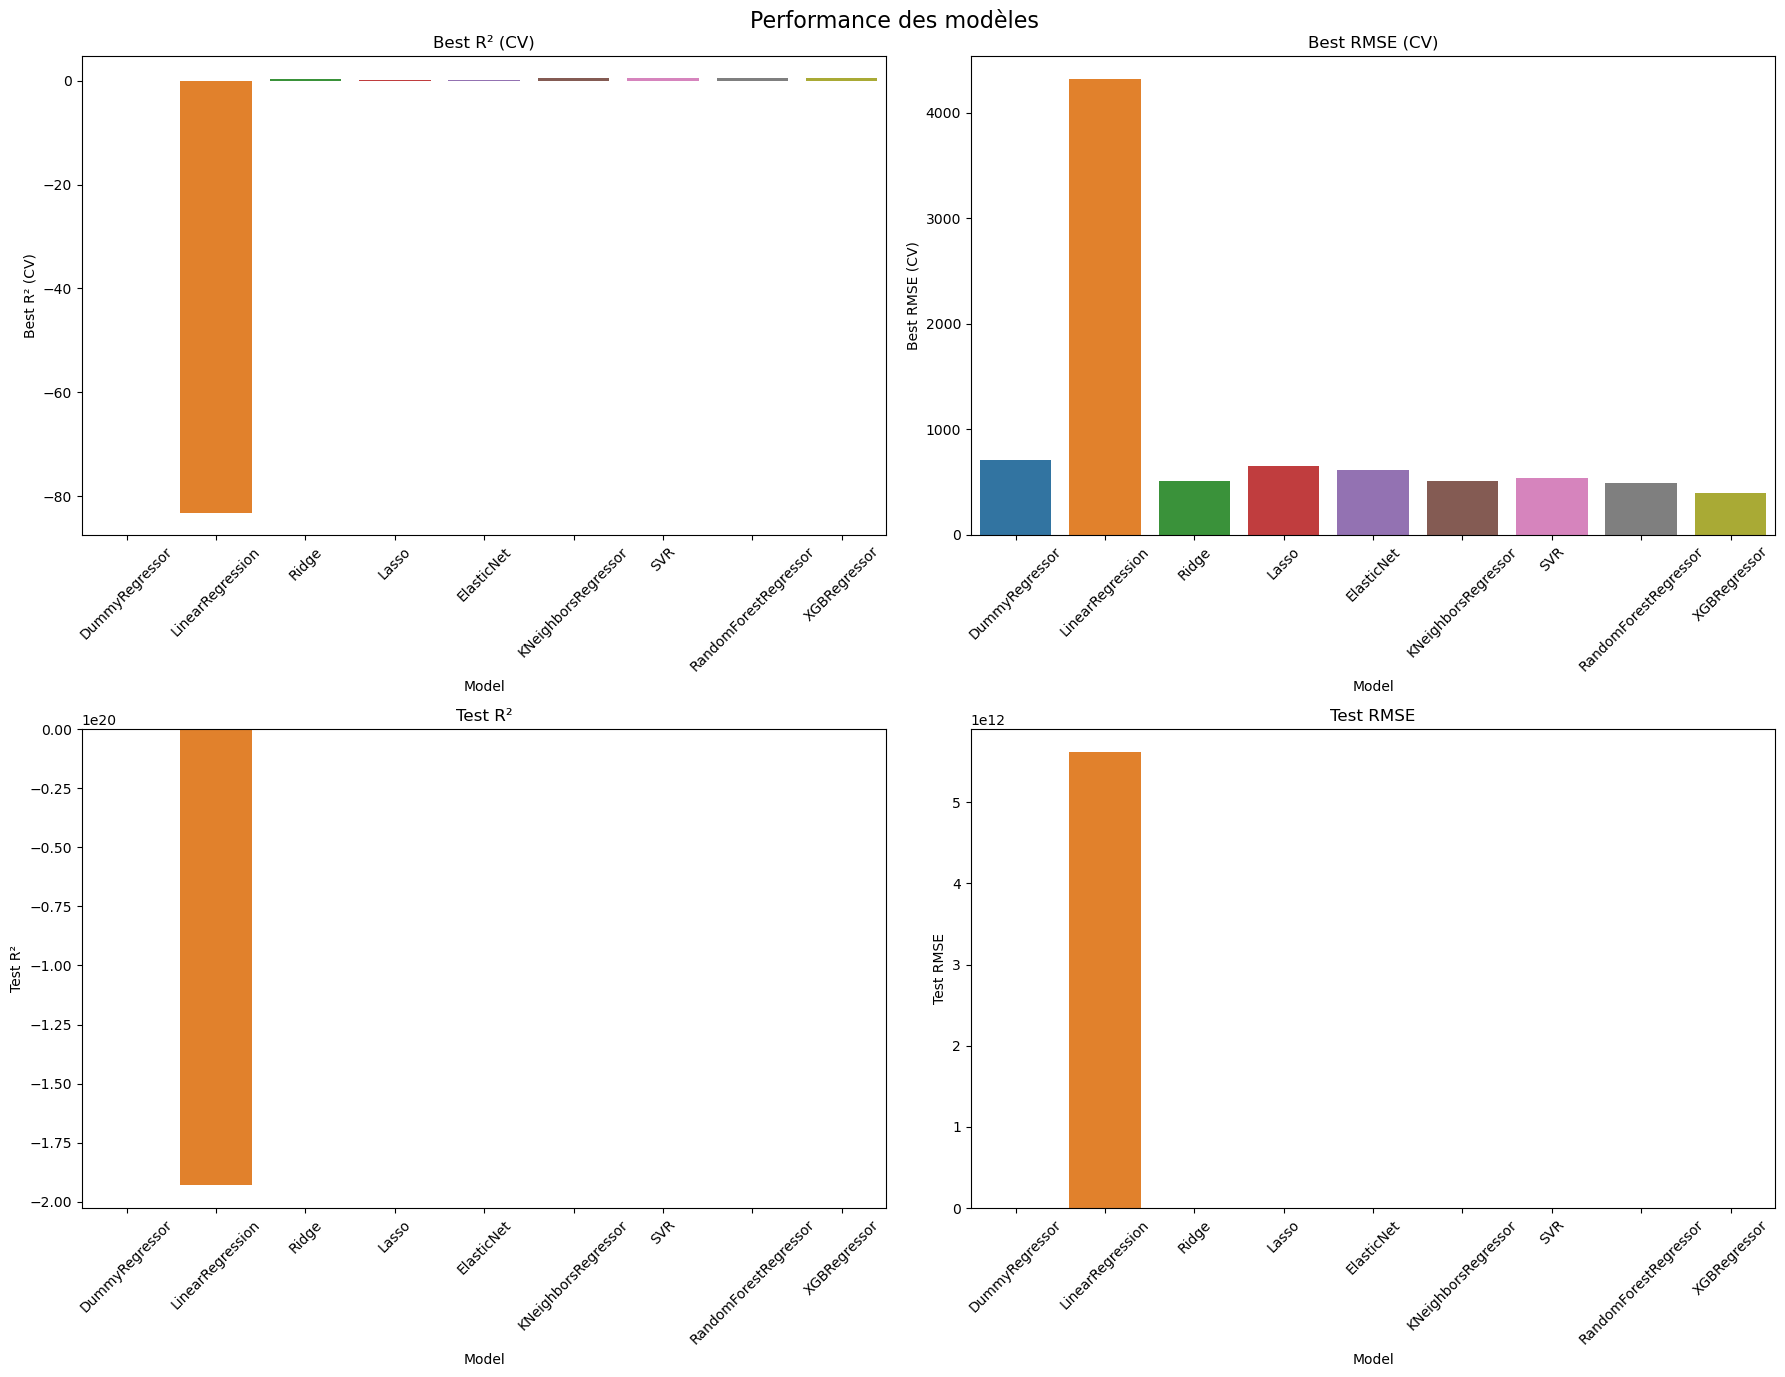

In [34]:
#R√©sultats des mod√®les sous forme de dictionnaire
results = {
    "Model": [
        "DummyRegressor", "LinearRegression", "Ridge", "Lasso", "ElasticNet",
        "KNeighborsRegressor", "SVR", "RandomForestRegressor", "XGBRegressor"
    ],
    "Best R¬≤ (CV)": [-0.057, -83.28, 0.286, 0.141, 0.193, 0.462, 0.459, 0.509, 0.628],
    "Best RMSE (CV)": [710.11, 4325.62, 511.83, 649.07, 615.29, 511.98, 539.19, 491.24, 395.01],  # RMSE toujours positif
    "Test R¬≤": [-0.0003, -1.93e20, -0.022, -0.015, 0.0065, -0.109, -0.043, -0.477, -1.177],
    "Test RMSE": [405.02, 5.62e12, 409.43, 408.01, 403.65, 426.36, 413.66, 492.22, 597.54]
}

# Convertir en DataFrame
df_results = pd.DataFrame(results)

# Configuration des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
axes = axes.flatten()

# Liste des m√©triques √† afficher
metric_result = ["Best R¬≤ (CV)", "Best RMSE (CV)", "Test R¬≤", "Test RMSE"]

for i, metrics_1 in enumerate(metric_result):
    sns.barplot(x="Model", y=metrics_1, data=df_results, ax=axes[i])
    axes[i].set_title(metrics_1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

#Ajout d'un titre global
fig.suptitle("Performance des mod√®les", fontsize=16) 

plt.tight_layout()
plt.show()

Avec le fonction gridsearch nous obtenons de meilleurs r√©sultats sur R¬≤, il faut utiliser cette fonction la pour la suite du projet.

Pour determiner le meilleur r√©sultat, il faut faire attention √† deux indicateurs :

R¬≤ (degr√© d'explication du mod√®le, plus il est proche de 1 mieux c'est) / RMSE (l'erreur quadratique moyenne MSE) plus elle est faible, mieux c'est.

## 3. Transformation

### 3.1 Feature engineering Manuel

In [35]:
#Copie les donn√©es pour √©viter de faire des modifs sur le fichier d'origine
data_manuel = data.copy()

In [36]:
#Feature engineering - ajout des rations avec une fonction
def compute_surface_ratios(X):
    X = X.copy()
    X['LargestPropertyUseRatio'] = X['LargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    X['SecondLargestPropertyUseRatio'] = X['SecondLargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    X['ThirdLargestPropertyUseRatio'] = X['ThirdLargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    
    #Ajout de l'√¢ge du b√¢timent
    X['YearBuilt'] = 2016 - X['BuildingAge']
    
    return X.drop(columns=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], errors='ignore')

In [37]:
#D√©finition des features et target
X_manuel = data_manuel.drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis=1, errors='ignore')
y_manuel = data_manuel['TotalGHGEmissions'] #Target

In [38]:
#S√©paration du dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(X_manuel, y_manuel, test_size=0.2, random_state=42)

In [39]:
#Remplacer les valeurs inf √† 0 par une m√©diane
y_train[y_train <= 0] = y_train.median()

In [40]:
#Appliquer la transformation
X_train = compute_surface_ratios(X_train)
X_test = compute_surface_ratios(X_test)

In [41]:
#D√©tection des colonnes quanti et quali apr√®s supression de colonnes
quanti = X_train.select_dtypes(include=['int64','float64']).columns
quali = X_train.select_dtypes(include=['category','object','bool']).columns

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

#Cr√©ation du pr√©processeur avec 'FunctionTransformer' pour le feature engineering
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), quanti),  # Normalisatddion des colonnes num√©riques
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), quali)  # Encodage des colonnes cat√©goriques
], remainder='passthrough')  # Garde les autres colonnes

In [43]:
#Ex√©cution de la GridSearchCV
df_resultats_manuel = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor_manuel)

GridSearch pour DummyRegressor...
 Meilleurs param√®tres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -539.5034368133232
 Meilleur score R2 : -0.07720658003510343

 √âvaluation sur le jeu de test :
 MAE (Test) : 186.02013501475005
 RMSE (Test) : 1123.1405826694659
 R¬≤ (Test) : -0.017542470695500745
GridSearch pour LinearRegression...
 Meilleurs param√®tres : {'regressor__fit_intercept': False, 'regressor__positive': True}
 Meilleur score RMSE : -4530.51972357053
 Meilleur score R2 : -64.29353734797436

 √âvaluation sur le jeu de test :
 MAE (Test) : 182.95532366509352
 RMSE (Test) : 1373.656954627009
 R¬≤ (Test) : -0.5220919309479397
GridSearch pour Ridge...
 Meilleurs param√®tres : {'regressor__alpha': 800}
 Meilleur score RMSE : -509.1461426171527
 Meilleur score R2 : 0.05024412238004457

 √âvaluation sur le jeu de test :
 MAE (Test) : 174.82311631626771
 RMSE (Test) : 1109.069213197549
 R¬≤ (Test) : 0.007794557880648978
GridSearch pour Lasso...
 Meilleurs param√®tres : 

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                          {'regressor__alpha': 800}   
3                  Lasso          {'regressor__alpha': 0.35100000000000003}   
4             ElasticNet  {'regressor__alpha': 0.46, 'regressor__l1_rati...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1        -64.293537        -4530.519724  
2          0.050244         -509.146143  
3          0.044634         -507.895163  
4          0.050840         -504.827596  
5          0.236879         -460.895833  
6          0.512036         -400.386760  
7          0.496569         -403.367215  
8          0.621792         -348.653699

In [44]:
df_resultats_manuel

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                          {'regressor__alpha': 800}   
3                  Lasso          {'regressor__alpha': 0.35100000000000003}   
4             ElasticNet  {'regressor__alpha': 0.46, 'regressor__l1_rati...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1        -64.293537        -4530.519724  
2          0.050244         -509.146143  
3          0.044634         -507.895163  
4          0.050840         -504.827596  
5          0.236879         -460.895833  
6          0.512036         -400.386760  
7          0.496569         -403.367215  
8          0.621792         -348.653699

Analyse des r√©sultats :

Parmi les diff√©rents mod√®les, ***XBRegressor*** se distingue comme le meilleur mod√®le avec le R¬≤ de 0.621792 et le plus faible RMSE de -348.653699, ce qui indique une tr√®s bonne capacit√© √† pr√©dire les valeurs. Il surpasse d'autres mod√®les en termes de performance, suivi de pr√®s par ***RandomForestRegressor*** (R¬≤ de 0.491271, RMSE de -405.710867) et ***SVR*** (R¬≤ de 0.512036, RMSE de -400.386760), qui montrent √©galement de bonne performances. 

Les mod√®les comme ***DummyRegressor*** et ***LinearRegression*** pr√©sentent de bien moins bons r√©sultats avec des R¬≤ tr√®s faibles et de RMSE √©lev√©s, indiquant une capacit√© de pr√©diction limit√©es.

***XGBoost est le meilleur avec un R¬≤ : 0.6217 et la plus faible erreur : -348.65***

### 3.2 Encoding

In [45]:
#Copie des donn√©es pour √©viter de modif le DF initial
data_encoding = data.copy()

In [46]:
#D√©tection des variables cat√©gorielles
cat_features = data_encoding.select_dtypes(include=['object']).columns.tolist()
print("Variables cat√©gorielles :", cat_features)

Variables cat√©gorielles : ['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [47]:
#S√©paration des features et target
y_encoding = data_encoding['TotalGHGEmissions'] #Target
X_encoding = data_encoding.drop(columns=['SiteEnergyUse(kBtu)','OSEBuildingID','TotalGHGEmissions','ENERGYSTARScore'], errors='ignore') #Features

In [48]:
#S√©paration du jeu d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(X_encoding, y_encoding, test_size=0.2, random_state=42)

print('Taille X_train:', X_train.shape)
print('Taille X_test:', X_test.shape)

Taille X_train: (1181, 18)
Taille X_test: (296, 18)


In [49]:
#Remplacer les valeurs inf √† 0 par une m√©diane
y_train[y_train <= 0] = y_train.median()

In [50]:
#D√©tection des colonnes num√©riques et cat√©gorielle apr√®s s√©paration
quanti = X_encoding.select_dtypes(include=['int64','float64']).columns.tolist()
quanli = [col for col in cat_features if col in X_encoding.columns] #Seulement celle pr√©sente dans X

In [51]:
import category_encoders as ce

#Cr√©ation du 'TargetEncoder' pour les variables cat√©gorielles
target_encoder = ce.TargetEncoder(cols=quali)

In [52]:
#D√©finition du pr√©processeur avec Target Encoding
preprocessor_encoding = ColumnTransformer([
    ('target_encoding', target_encoder, quali), #Encode les variables cat√©gorielles avec Target Encoding
    ('scaling', StandardScaler(), quanti) #Standardisation des variables num√©riques
], remainder='passthrough') #COnserve les autres colonnes non sp√©cifiques

In [53]:
#Ex√©cution de la GridSearchCV avec le nouveau pr√©processor
preprocessor = preprocessor_encoding #Remplacement par le pr√©processor Target Encoding

In [54]:
df_results_encoding = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

GridSearch pour DummyRegressor...
 Meilleurs param√®tres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -539.5034368133232
 Meilleur score R2 : -0.07720658003510343

 √âvaluation sur le jeu de test :
 MAE (Test) : 186.02013501475005
 RMSE (Test) : 1123.1405826694659
 R¬≤ (Test) : -0.017542470695500745
GridSearch pour LinearRegression...
 Meilleurs param√®tres : {'regressor__fit_intercept': False, 'regressor__positive': False}
 Meilleur score RMSE : -83027.23177551388
 Meilleur score R2 : -24736.472823802214

 √âvaluation sur le jeu de test :
 MAE (Test) : 326.41458313204447
 RMSE (Test) : 2058.9435468623165
 R¬≤ (Test) : -2.4195832668896142
GridSearch pour Ridge...
 Meilleurs param√®tres : {'regressor__alpha': 1800}
 Meilleur score RMSE : -14183.348743272563
 Meilleur score R2 : -722.9441551288212

 √âvaluation sur le jeu de test :
 MAE (Test) : 227.09524729091808
 RMSE (Test) : 1443.8050742122475
 R¬≤ (Test) : -0.6815176595725023
GridSearch pour Lasso...
 Meilleurs param√®tr

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1800}   
3                  Lasso           {'regressor__alpha': 0.9510000000000001}   
4             ElasticNet  {'regressor__alpha': 0.9600000000000001, 'regr...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1     -24736.472824       -83027.231776  
2       -722.944155       -14183.348743  
3        -24.271796        -2903.322361  
4        -25.276924        -2959.680980  
5          0.226838         -456.918759  
6          0.253278         -471.711474  
7          0.578779         -359.792092  
8          0.598342         -342.295717

In [55]:
df_results_encoding

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1800}   
3                  Lasso           {'regressor__alpha': 0.9510000000000001}   
4             ElasticNet  {'regressor__alpha': 0.9600000000000001, 'regr...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1     -24736.472824       -83027.231776  
2       -722.944155       -14183.348743  
3        -24.271796        -2903.322361  
4        -25.276924        -2959.680980  
5          0.226838         -456.918759  
6          0.253278         -471.711474  
7          0.578779         -359.792092  
8          0.598342         -342.295717

Analyse des r√©sultats : 

En conclusion, ***XGBRegressor*** se d√©marque une fois de plus comme le mod√®le le plus performant, avec un R¬≤ de 0.598342 et un RMSE de -342.295717, indiquant une bonne capacit√© de pr√©diction. Il est suivi de pr√®s par RandomForestRegressor (R¬≤ de 0.578779, RMSE de -359.792092), qui affiche √©galement des performances solides. SVR (R¬≤ de 0.253278) et KNeighborsRegressor (R¬≤ de 0.226838) montrent des r√©sultats interm√©diaires, mais restent loin derri√®re les mod√®les bas√©s sur les arbres.

En revanche, les mod√®les LinearRegression, Ridge, Lasso et ElasticNet pr√©sentent des R¬≤ n√©gatifs et des RMSE tr√®s √©lev√©s, indiquant qu'ils ne parviennent pas √† bien s'adapter aux donn√©es. DummyRegressor, avec un R¬≤ proche de z√©ro, confirme son r√¥le de simple r√©f√©rence.

Ainsi, pour cette t√¢che de r√©gression, XGBRegressor appara√Æt comme le mod√®le le plus performant, suivi par RandomForestRegressor, tandis que les mod√®les lin√©aires montrent de tr√®s faibles performances.

***XGBoost a les meilleurs r√©sultats ici : 0.598 de r¬≤ et -342.29 de RMSE (erreur)***

### 3.3 Log

In [56]:
#Copie des donn√©es
data_log = data.copy()

In [57]:
#Appliquer log(1+x) sur toutes les features num√©riques via un transformateur
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [58]:
#Correction de la s√©lection des features
X_log = data_log.drop(columns=['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], errors='ignore')
y_log = np.log1p(data_log['TotalGHGEmissions']) #Appliquer log √† y

In [59]:
#S√©paration train/test
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [60]:
#Remplacer les valeurs inf √† 0 par une m√©diane
y_train[y_train <= 0] = y_train.median()

In [61]:
#D√©finition du pr√©processeur avec log-transform sur les variables num√©riques
preprocessor_log = ColumnTransformer([
    ('log_transform', log_transformer, X_log.select_dtypes(include=['number']).columns),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), X_log.select_dtypes(include=['object']).columns)
])

In [62]:
#Ex√©cution de la GridSearchCV avec le nouveau pr√©processor
preprocessor = preprocessor_log #Remplacement par le pr√©processor Target Encoding 

In [63]:
df_results_log = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

GridSearch pour DummyRegressor...
 Meilleurs param√®tres : {'regressor__strategy': 'median'}
 Meilleur score RMSE : -1.4316782860310324
 Meilleur score R2 : -0.006977103180540611

 √âvaluation sur le jeu de test :
 MAE (Test) : 1.1770586549086424
 RMSE (Test) : 1.5131517181981842
 R¬≤ (Test) : -0.013709537336099142
GridSearch pour LinearRegression...
 Meilleurs param√®tres : {'regressor__fit_intercept': True, 'regressor__positive': False}
 Meilleur score RMSE : -1.094538192080525
 Meilleur score R2 : 0.409099827157843

 √âvaluation sur le jeu de test :
 MAE (Test) : 0.8153190764015005
 RMSE (Test) : 1.1142491724334656
 R¬≤ (Test) : 0.4503158400266528
GridSearch pour Ridge...
 Meilleurs param√®tres : {'regressor__alpha': 200}
 Meilleur score RMSE : -1.0887976100394154
 Meilleur score R2 : 0.41684728507796703

 √âvaluation sur le jeu de test :
 MAE (Test) : 0.923288198401748
 RMSE (Test) : 1.1632201143835608
 R¬≤ (Test) : 0.4009371495235171
GridSearch pour Lasso...
 Meilleurs param√®tres

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                  {'regressor__strategy': 'median'}   
1       LinearRegression  {'regressor__fit_intercept': True, 'regressor_...   
2                  Ridge                          {'regressor__alpha': 200}   
3                  Lasso                        {'regressor__alpha': 0.001}   
4             ElasticNet  {'regressor__alpha': 0.01, 'regressor__l1_rati...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.006977           -1.431678  
1          0.409100           -1.094538  
2          0.416847           -1.088798  
3          0.511502           -0.996269  
4          0.492712           -1.015576  
5          0.386050           -1.116445  
6          0.536513           -0.970748  
7          0.505833           -1.001744  
8          0.521762           -0.985758

In [64]:
df_results_log

Mod√®le                               Meilleurs Param√®tres  \
0         DummyRegressor                  {'regressor__strategy': 'median'}   
1       LinearRegression  {'regressor__fit_intercept': True, 'regressor_...   
2                  Ridge                          {'regressor__alpha': 200}   
3                  Lasso                        {'regressor__alpha': 0.001}   
4             ElasticNet  {'regressor__alpha': 0.01, 'regressor__l1_rati...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)  
0         -0.006977           -1.431678  
1          0.409100           -1.094538  
2          0.416847           -1.088798  
3          0.511502           -0.996269  
4          0.492712           -1.015576  
5          0.386050           -1.116445  
6          0.536513           -0.970748  
7          0.505833           -1.001744  
8          0.521762           -0.985758

Analyse des r√©sultats : 

En conclusion, ***SVR*** se r√©v√®le √™tre le mod√®le le plus performant avec un R¬≤ de 0.536513 et un RMSE de -0.970748, ce qui indique une bonne capacit√© pr√©dictive. Il est suivi de pr√®s par XGBRegressor (R¬≤ de 0.521762, RMSE de -0.985758) et Lasso (R¬≤ de 0.511502, RMSE de -0.996269), qui offrent √©galement de bons r√©sultats.

Les mod√®les RandomForestRegressor (R¬≤ de 0.505833) et ElasticNet (R¬≤ de 0.492712) montrent des performances l√©g√®rement inf√©rieures, tandis que LinearRegression (R¬≤ de 0.409100) et KNeighborsRegressor (R¬≤ de 0.386050) restent en retrait. DummyRegressor, avec un R¬≤ proche de z√©ro, sert simplement de base de comparaison.

Ainsi, SVR appara√Æt comme le mod√®le le plus adapt√© √† cette t√¢che de r√©gression, suivi de XGBRegressor et Lasso, qui constituent √©galement de bons choix pour obtenir des pr√©dictions pr√©cises.

***SVR est le meilleur mod√®le avec un meilleur r¬≤ (0.5365) et RMSE (-0.9707)***


### 3.4 R√©sultats

In [65]:
#Reporting r√©sultat avec cv_result.
#Ajout d'une colonne pour savoir de quel m√©thode on parle
df_resultats_manuel['transformation'] = 'Feature Engineering Manuel'
df_results_encoding['transformation'] = 'Target Encoding'
df_results_log['transformation'] = 'Logarithmique'

In [66]:
#Concatene les trois tableaux de r√©sultats
#Fusion les trois r√©sultats
df_final_results = pd.concat([df_resultats_manuel, df_results_encoding, df_results_log], ignore_index=True)

#Afficher un aper√ßu
display(df_final_results.head())

Mod√®le                               Meilleurs Param√®tres  \
0    DummyRegressor                    {'regressor__strategy': 'mean'}   
1  LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2             Ridge                          {'regressor__alpha': 800}   
3             Lasso          {'regressor__alpha': 0.35100000000000003}   
4        ElasticNet  {'regressor__alpha': 0.46, 'regressor__l1_rati...   

   Meilleur R¬≤ (CV)  Meilleur RMSE (CV)              transformation  
0         -0.077207         -539.503437  Feature Engineering Manuel  
1        -64.293537        -4530.519724  Feature Engineering Manuel  
2          0.050244         -509.146143  Feature Engineering Manuel  
3          0.044634         -507.895163  Feature Engineering Manuel  
4          0.050840         -504.827596  Feature Engineering Manuel

In [67]:
#Meilleur mod√®le pour chaque transformation
df_best_results = df_final_results.loc[df_final_results.groupby("transformation")["Meilleur R¬≤ (CV)"].idxmax()]

#Trier les r√©sultats par performance
df_best_results = df_best_results.sort_values(by="Meilleur R¬≤ (CV)", ascending=False)

#Afficher les meilleurs mod√®les pour chaque transformation
display(df_best_results)

Mod√®le                               Meilleurs Param√®tres  \
8   XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   
17  XGBRegressor  {'regressor__gamma': 0.01, 'regressor__learnin...   
24           SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   

    Meilleur R¬≤ (CV)  Meilleur RMSE (CV)              transformation  
8           0.621792         -348.653699  Feature Engineering Manuel  
17          0.598342         -342.295717             Target Encoding  
24          0.536513           -0.970748               Logarithmique

Choix de r√©sultat: 

En conclusion, ***XGBRegressor*** se r√©v√®le √™tre le mod√®le le plus performant avec un R¬≤ de 0.621792 et un RMSE de -348.653699 lorsque la transformation est bas√©e sur du Feature Engineering Manuel. Il surpasse ainsi le m√™me mod√®le XGBRegressor utilisant la m√©thode de Target Encoding (R¬≤ de 0.598342, RMSE de -342.295717), mais avec une l√©g√®re diff√©rence en termes de performances.

Un autre mod√®le notable est SVR (R¬≤ de 0.536513, RMSE de -0.970748), qui, bien que performant, reste derri√®re les deux mod√®les XGBRegressor. Ce mod√®le a √©t√© √©valu√© apr√®s une transformation logarithmique, ce qui peut expliquer une performance l√©g√®rement inf√©rieure √† celle de XGBRegressor.

En r√©sum√©, ***XGBRegressor avec Feature Engineering Manuel*** se montre comme le mod√®le optimal, suivi de XGBRegressor avec Target Encoding et SVR avec transformation logarithmique, qui offrent √©galement des r√©sultats solides mais moins bons que les versions bas√©es sur XGBRegressor.

### 3.5 Fine Tuning

In [68]:
#D√©finition de la grille d'hyperparam√®tres pour le fine-tuning
params_grid_finetune = {
    'regressor__gamma': [0.03, 0.05, 0.075, 0.1],  
    'regressor__learning_rate': [0.005, 0.01, 0.02, 0.04, 0.05, 0.06],  
    'regressor__max_depth': [3, 4, 5, 6, 7],  
    'regressor__n_estimators': [400, 450, 500, 550]  
}

In [69]:
#Cr√©ation du pipeling avec le preprocessor_manuel et XGBRegressor
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor_manuel),
    ('regressor', XGBRegressor(random_state=42))
])

In [70]:
#Lancement du GridSearchCV avec validation crois√©e (CV=5)
grid_search_finetune = GridSearchCV(
    estimator=pipeline_xgb, #Utilisation du pipeline complet
    param_grid=params_grid_finetune, #Grille d'hyperparam√®tres √† tester
    cv=5, #Validation crois√©e avec 5 folds
    scoring=('r2', 'neg_root_mean_squared_error'), #Optimisation de R¬≤ et RMSE
    refit='r2', #S√©lection du meilleur mod√®le bas√© sur R¬≤
    n_jobs=-1, #Utilisation maximales du CPU pour acc√®l√©rer
    verbose=3, #Affichage des loges d√©taill√©s sur la progression de GridSearch
)

In [71]:
print("Colonnes avant transformation :", X_test.columns)
print("Colonnes avant transformation :", X_train.columns)

Colonnes avant transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')
Colonnes avant transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtyp

In [72]:
#Appliquer la transformation
X_train = compute_surface_ratios(X_train)
X_test = compute_surface_ratios(X_test)

In [73]:
print("Colonnes Apr√®s transformation :", X_test.columns)
print("Colonnes Apr√®s transformation :", X_train.columns)

Colonnes Apr√®s transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'BuildingAge', 'ElectricityUse',
       'SteamUse', 'NaturalGasUse', 'SteamUseMost', 'NaturalGasUseMost',
       'ElectricityUseMost', 'ParkingRatioGFA', 'MoreThan1Building',
       'LargestPropertyUseRatio', 'SecondLargestPropertyUseRatio',
       'ThirdLargestPropertyUseRatio', 'YearBuilt'],
      dtype='object')
Colonnes Apr√®s transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'BuildingAge', 'ElectricityUse',
       'SteamUse', 'NaturalGasUse', 'SteamUseMost', 'NaturalGasUseMost',
       'ElectricityUseMost', 'ParkingRatioGFA', 'MoreThan1Building',
       'LargestPropertyUseRatio', 'SecondLargestPropertyUseRatio',
       'ThirdLargestPropertyUseRatio', 'YearBui

In [74]:
#Entra√Ænement du mod√®le sur les donn√©es transform√©es
grid_search_finetune.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('quanti',
                                                                         StandardScaler(),
                                                                         Index(['NumberofFloors', 'PropertyGFATotal', 'BuildingAge', 'ParkingRatioGFA',
       'LargestPropertyUseRatio', 'SecondLargestPropertyUseRatio',
       'ThirdLargestPropertyUseRatio', 'YearBuilt'],
      dtype='object')),
                                                                        ('quali',
                                                                         OneH...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=Non

In [75]:
#R√©cup√©ration du meilleur mod√®le apr√®s le GridSearch
best_xgb_model = grid_search_finetune.best_estimator_

In [76]:
#Pr√©dictions sur les donn√©es de test
y_pred = best_xgb_model.predict(X_test)

In [77]:
#Calcul des m√©triques de performance
r2_final = r2_score(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

In [78]:
#Affichage des r√©sultats
print("\nüéØ Meilleurs hyperparam√®tres trouv√©s :", grid_search_finetune.best_params_)
print(f"‚úÖ R¬≤ final sur test : {r2_final:.4f}")
print(f"üìâ RMSE final sur test : {rmse_final:.4f}")


üéØ Meilleurs hyperparam√®tres trouv√©s : {'regressor__gamma': 0.03, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 500}
‚úÖ R¬≤ final sur test : 0.7234
üìâ RMSE final sur test : 0.7904


Analyse des r√©sultats : ***meilleurs hyperparam√®tres***

- Gamma -> 0.03: r√©gularisation l√©g√®re, ce qui emp√™che le sur-apprentissage
- Learning rate -> 0.05: valeur mod√©r√©e, permet une convergence stable 
- Max depth -> 3: profondeur assez faible pour √©viter trop de complexit√©
- n_estimators -> 500: plus d'arbres pour am√©liorer l'ajustement

***R¬≤ de 0.7234, mod√®le explique environ 72,34% de la variance dans les donn√©es de test***. bon pouvoir explicatif du mod√®le

***RMSE de 0.7904, signifie que l'erreur de pr√©diction est faible.*** Les pr√©dictions du mod√®le sont relativement pr√©cises par rapport aux valeurs r√©elles de l'√©nergie utilis√©e par les b√¢timents.

## 4. Feature Importance

Dimensions de X_train_transformed_df : (1181, 158)
Dimensions de X_test_transformed_df : (296, 158)


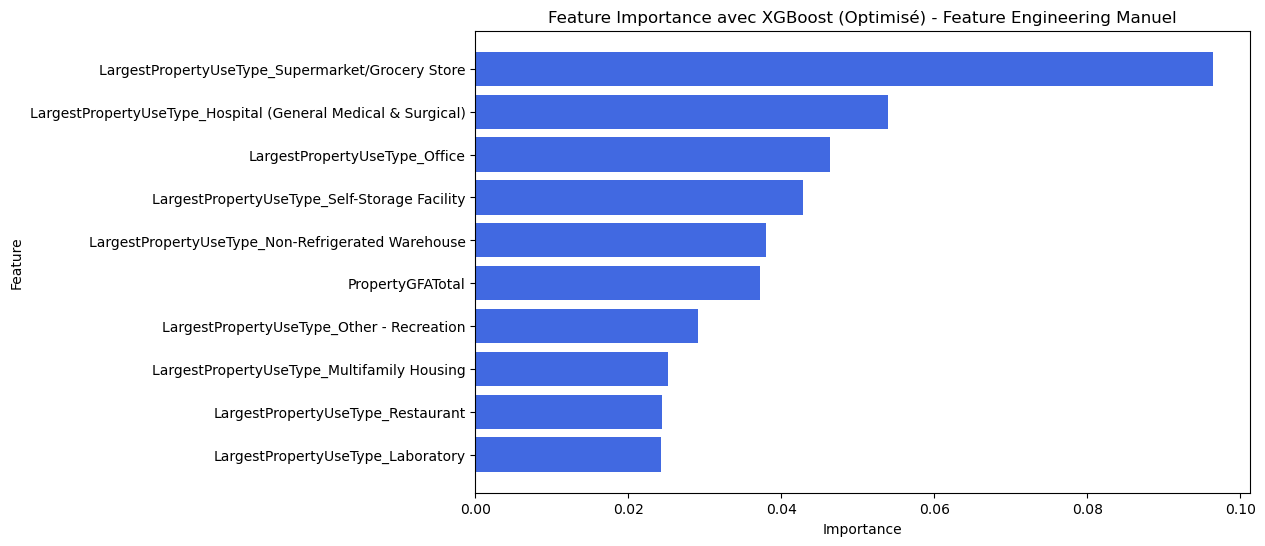

In [79]:
#Feature Importance globale
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import pandas as pd

# Transformation des donn√©es avec le pr√©processeur
X_train_transformed = preprocessor_manuel.fit_transform(X_train)
X_test_transformed = preprocessor_manuel.transform(X_test)  # Utilisez transform() sur X_test pour √©viter la divergence

#S√©lection des features num√©riques et cat√©gorielles
num_features = X_train.select_dtypes(include=['number']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

#D√©finition du pr√©processeur avec StandardScaler pour les features num√©riques + OneHotEncoder pour les cat√©gorielles
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), num_features),  # Normalisation des variables num√©riques
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features)  # Encodage des variables cat√©gorielles
])

#Transformation des donn√©es
X_train_transformed = preprocessor_manuel.fit_transform(X_train)
X_test_transformed = preprocessor_manuel.transform(X_test)

#Extraction des noms des colonnes apr√®s transformation
num_feature_names = num_features  # Les colonnes num√©riques conservent leurs noms d'origine
cat_feature_names = preprocessor_manuel.named_transformers_['quali'].get_feature_names_out(cat_features)  # Colonnes apr√®s OneHot

#Fusionner tous les noms de colonnes
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

#Conversion en DataFrame avec les bons noms de colonnes
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names, index=X_test.index)

#V√©rification des dimensions
print(f"Dimensions de X_train_transformed_df : {X_train_transformed_df.shape}")
print(f"Dimensions de X_test_transformed_df : {X_test_transformed_df.shape}")

#Initialisation et entra√Ænement du mod√®le XGBoost avec les meilleures hyperparam√®tres
best_params = {
    "regressor__gamma": 0.25,
    "regressor__learning_rate": 0.06,
    "regressor__max_depth": 2,
    "regressor__n_estimators": 375,
    "random_state": 42
}

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_transformed_df, y_train)

#Feature importance globale
feature_importances = xgb_model.feature_importances_

#Cr√©ation d'un DataFrame pour afficher les importances
importances_df = pd.DataFrame({
    "Feature": X_train_transformed_df.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

#Affichage des 10 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"][:10], importances_df["Importance"][:10], color="royalblue")
plt.gca().invert_yaxis()  # Afficher les plus importantes en haut
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance avec XGBoost (Optimis√©) - Feature Engineering Manuel")
plt.show()

Analyse des r√©sultats : 

- LargestPropertyUseType_Supermaket/Grocery Store est la variable la plus influente sur la pr√©diction de la consommation d'√©nergie. 
- PropertyGFATotal (surface total du b√¢timent) a √©galement un fort impact, logique, car la consommation √©nerg√©tique est fortement li√©e √† la taille du b√¢timent.
- Plusieurs types d'utilisation du b√¢timents sont d√©terminant (Office, hospital, restaurant)
- Les ratios de surface ont moins d'importance. 

B√¢timent 529 - Consommation d'√©nergie pr√©dit :  3.73 kBtu
 Waterfall Plot :


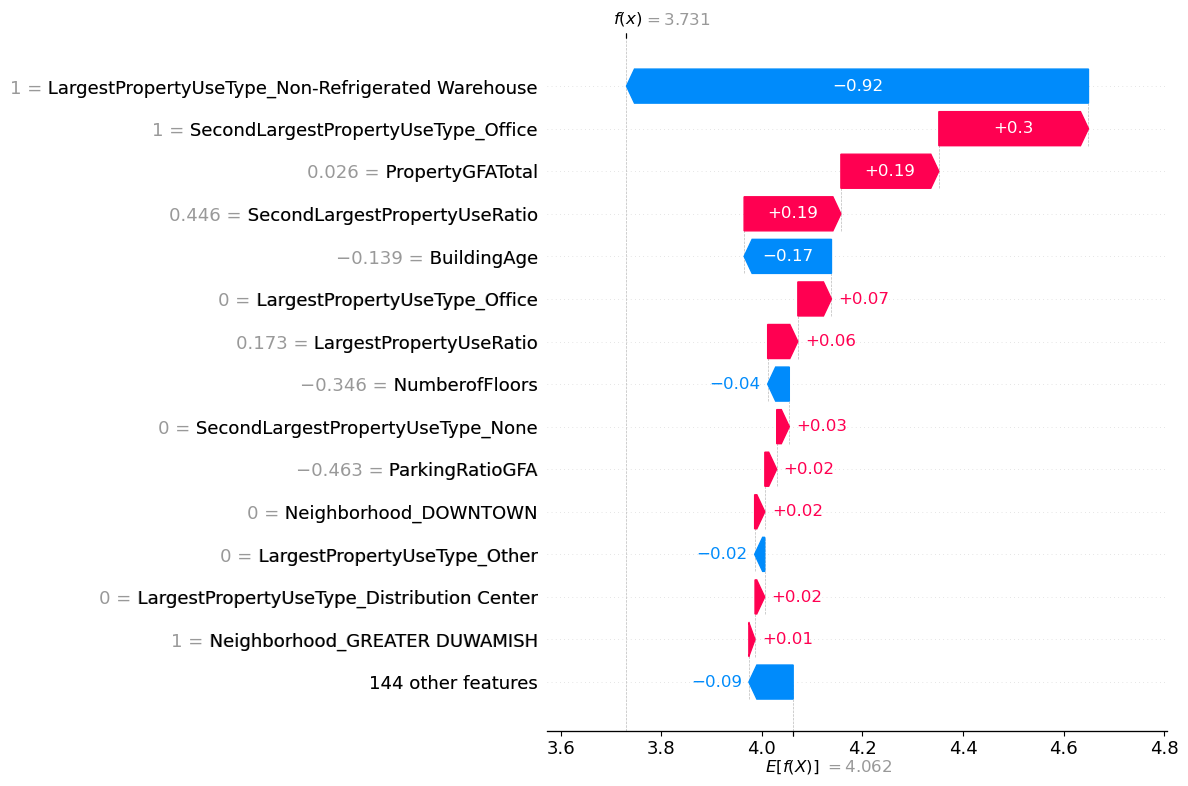

 Force plot :


In [80]:
import shap

#S√©lection d'un b√¢timent
X_local_1 = X_test_transformed_df.loc[[529]] #Index 529
y_pred_1 = xgb_model.predict(X_local_1)

#Affichage de la pr√©d
batiment_id = X_local_1.index[0]
print(f"B√¢timent {batiment_id} - Consommation d'√©nergie pr√©dit : {y_pred_1[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_1 = explainer(X_local_1)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_1[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_1[0])

Analyse graphique pour le b√¢timent 529 (pr√©diction de 3.73 Kbtu) :

Facteurs r√©ducteurs majeurs:

- LargestPropertyUseType_Non-Refrigerated Warehouse (-0.92) : L'usage principal en tant qu'entrep√¥t non r√©frig√©r√© r√©duit significativement la consommation d'√©nergie.
- BuildingAge (-0.17) : Un √¢ge de b√¢timent plus √©lev√© r√©duit la consommation, ce qui est inhabituel mais pourrait √™tre d√ª √† des r√©novations ou des am√©liorations √©nerg√©tiques.
- NumberofFloors (-0.04) : Un nombre √©lev√© d'√©tages r√©duit l√©g√®rement la consommation.

Facteurs amplificateurs:

- SecondLargestPropertyUseType_Office (+0.30) : L'usage secondaire en tant que bureau augmente la consommation d'√©nergie.
- PropertyGFATotal (+0.19) : Une grande surface totale augmente la consommation.
- SecondLargestPropertyUseRatio (+0.19) : Un ratio √©lev√© d'usage secondaire augmente la consommation.
- Neighborhood_GREATER DUWAMISH (+0.01) : La localisation dans le quartier Greater Duwamish augmente l√©g√®rement la consommation.

B√¢timent 901 - Consommation d'√©nergie pr√©dit :  3.81 kBtu
 Waterfall Plot :


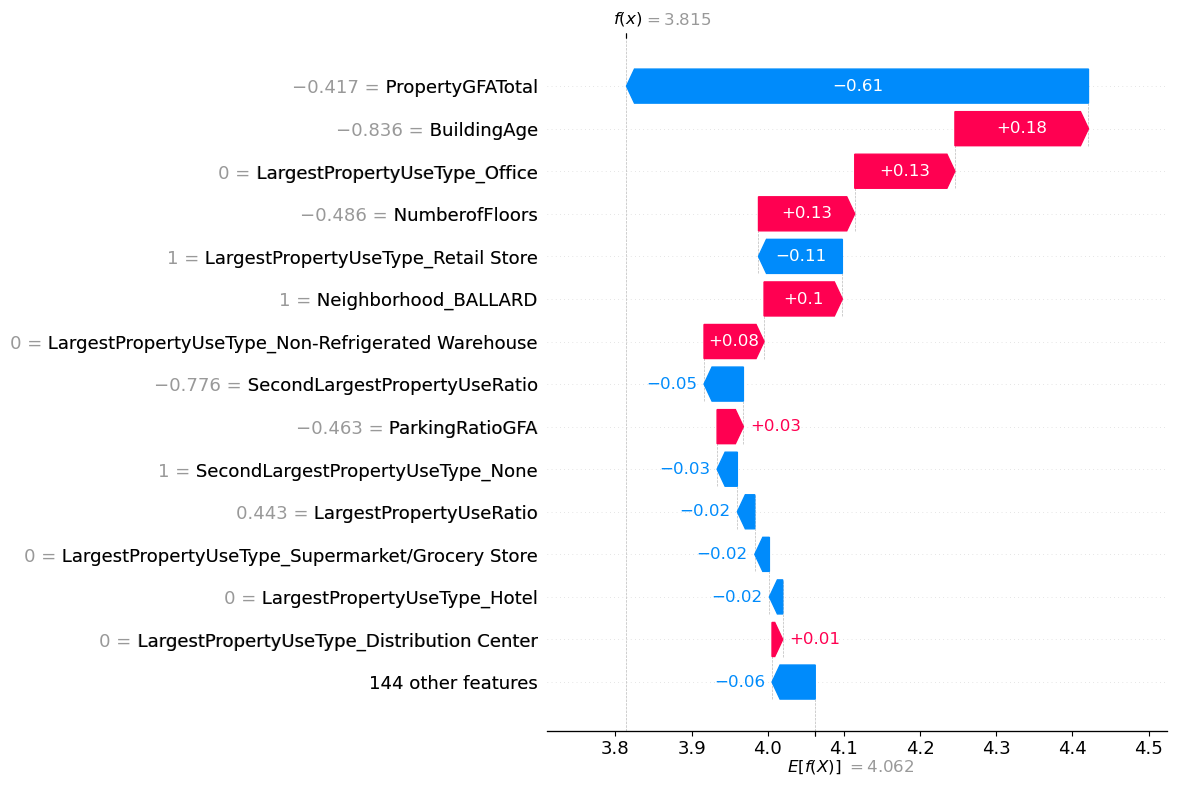

 Force plot :


In [81]:
#S√©lection d'un b√¢timent
X_local_2 = X_test_transformed_df.loc[[901]] #Index 772
y_pred_2 = xgb_model.predict(X_local_2)

#Affichage de la pr√©d
batiment_id = X_local_2.index[0]
print(f"B√¢timent {batiment_id} - Consommation d'√©nergie pr√©dit : {y_pred_2[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_2 = explainer(X_local_2)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_2[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_2[0])

Analyse graphique pour le b√¢timent 901 (pr√©diction de 3.81 Kbtu) :

Facteurs r√©ducteurs majeurs:

- PropertyGFATotal (-0.61): une grande surface totale r√©duit la consommation d'√©nergie
- NumberofFloors (-0.49): Un nombre d'√©tage √©lev√© r√©duit la consommation d'√©nergie

Facteur amplificateur:

- BuildingAge (+0.18) : Un √¢ge de b√¢timent plus √©lev√© augmente la consommation.
- LargestPropertyUseType_Office (+0.13) : L'usage principal en tant que bureau augmente la consommation.
- Neighborhood_BALLARD (+0.10) : La localisation dans le quartier Ballard augmente la consommation.

B√¢timent 772 - Consommation d'√©nergie pr√©dit :  2.78 kBtu
 Waterfall Plot :


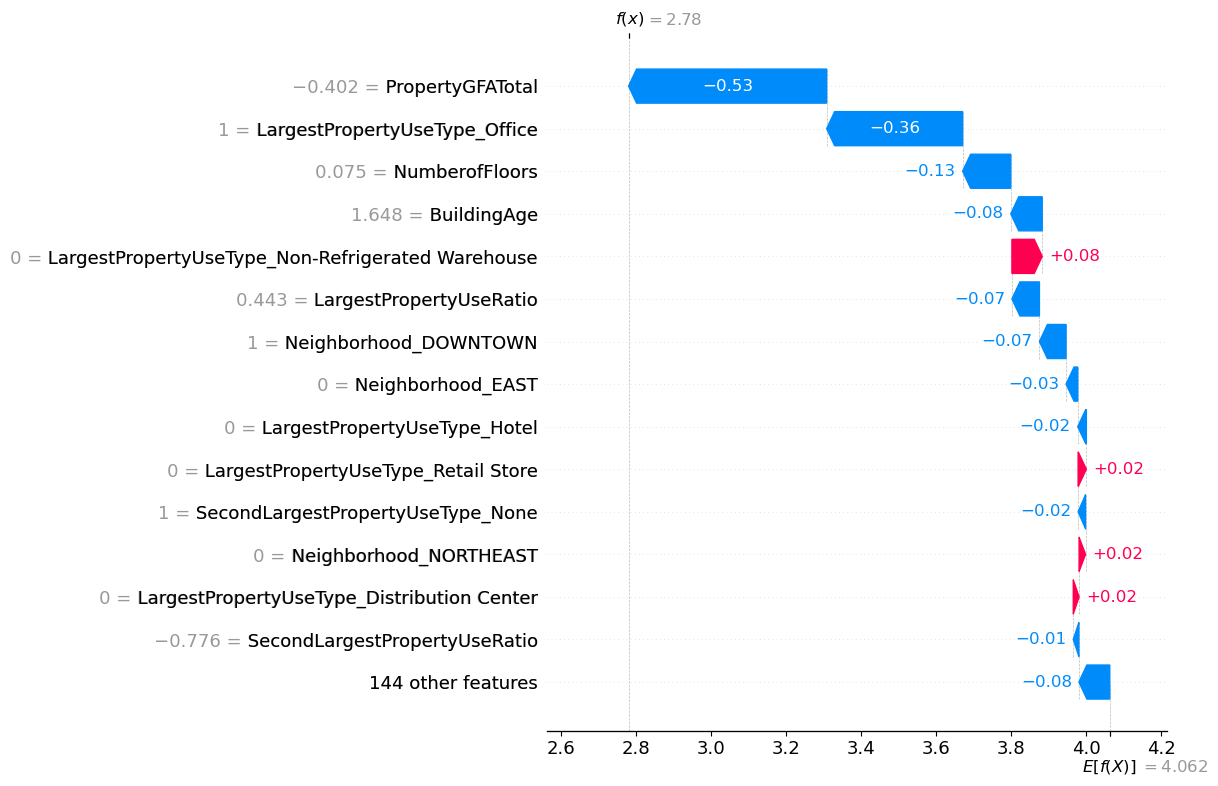

 Force plot :


In [82]:
#S√©lection d'un b√¢timent
X_local_3 = X_test_transformed_df.loc[[772]] #Index 772
y_pred_3 = xgb_model.predict(X_local_3)

#Affichage de la pr√©d
batiment_id = X_local_3.index[0]
print(f"B√¢timent {batiment_id} - Consommation d'√©nergie pr√©dit : {y_pred_3[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_3 = explainer(X_local_3)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_3[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_3[0])

Analyse graphique pour le b√¢timent 772 (pr√©diction de 2.78 Kbtu) :

Facteurs r√©ducteurs majeurs:

- PropertyGFATotal (-0.53) : une grande surface totale r√©duit la consommation d'√©nergie
- LargestPropertyUseType_Office (-0.36) : L'usage principal en tant que bureau r√©duit la consommation
- NumberOfFloors (-0.13): Un nombre √©lev√© d'√©tages r√©duit √©galement la consommation

Facteur amplificateur:

- LargestPropertyUseType_Non-Refrigerated Warehouse (+0.08) : L'usage en tant qu'entrep√¥t non r√©frig√©r√© augmente l√©g√®rement la consommation 
- Neighborhood_NORTHEAST (+0.02) : La localisation dans le quartier (ici Nord-Est) augmente la consommation d'√©nergie

***Conclusion:***

- La taille du b√¢timent √† souvent un effet r√©ducteur sur la consommation d'√©nergie, surtout pour les grandes surfaces.
- √Çge du b√¢timent peut jouer dans les deux sens, les b√¢timents plus anciens ont tendance √† consommer plus d'√©nergie, d√ª √† l'inefficacit√© √©nergitique.
- Type d'usage principal est d√©terminant, les entrep√¥ts non r√©frig√©r√©s consomment g√©n√©ralement moins d'√©nergie, tandis que d'autres types de b√¢timents (commerces ou bureaux) peuvent influencer diff√©remment la consommation
- La localisation est √©galement un facteur important, certains quartiers sont associ√©s √† des consommations d'√©nergies plus √©lev√®es, cela peut √™tre d√ª √† la diff√©rence d'√©quipement du quartier ou des infra locales.


## Impact Energy Star Score

In [83]:
#Copie les donn√©es et pr√©pare X et y
X_ESS = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y_ESS = data.copy()['TotalGHGEmissions'] 

In [84]:
#S√©parer train/test AVANT de supprimer les NaN
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS, y_ESS, test_size=0.2, random_state=42)

In [85]:
#Calcul de la m√©diane sur le train uniquement pour √©viter la fuite de donn√©es
median_score = X_train_ESS['ENERGYSTARScore'].median()

#Remplacement des NaN par la m√©diane pour √©viter la fuite de donn√©es
X_train_ESS['ENERGYSTARScore'].fillna(median_score, inplace=True)
X_test_ESS['ENERGYSTARScore'].fillna(median_score, inplace=True)

#je remplace au lieu de supprimer, pour garder plus d'√©chantillons, pas de perte de structure, limite le sur-apprentissage.

#Supprimer les lignes ou 'ENERGYSTARScore' est NaN
#X_train_ESS = X_train_ESS.dropna(subset=['ENERGYSTARScore'])
#X_test_ESS = X_test_ESS.dropna(subset=['ENERGYSTARScore'])

In [86]:
#Remplacer les valeurs inf √† 0 par une m√©diane
y_train_ESS[y_train_ESS <= 0] = y_train_ESS.median()

In [87]:
#Ajouter y_train et y_test pour garder les bons indices
y_train_ESS = y_train_ESS.loc[X_train_ESS.index]
y_test_ESS = y_test_ESS.loc[X_test_ESS.index]

In [88]:
#Appliquer la transformation
#X_train_ESS = compute_surface_ratios(X_train_ESS)
#X_test_ESS = compute_surface_ratios(X_test_ESS)

In [89]:
#S√©parer les features quantitatives et qualitatives
quanti_ESS = X_train_ESS.select_dtypes(include=['int32', 'float64']).columns
quali_ESS = X_train_ESS.select_dtypes(include=['category', 'object', 'bool']).columns

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

#Cr√©ation du pr√©processeur avec 'FunctionTransformer' pour le feature engineering
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), quanti_ESS),  #Normalisatddion des colonnes num√©riques
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), quali_ESS)  # Encodage des colonnes cat√©goriques
], remainder='passthrough')  # Garde les autres colonnes

In [91]:
#D√©finition du mod√®le XGBoost avec les meilleurs hyperparam√®tres
xgb_model = XGBRegressor(
    gamma=0.03, 
    learning_rate=0.05, 
    max_depth=3,  
    n_estimators=500, 
    random_state=42
)

#Cr√©ation du pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor_manuel),
    ('regressor', xgb_model)
])

#Entra√Ænement du pipeline
pipeline.fit(X_train_ESS, y_train_ESS)

#√âvaluation du mod√®le
train_score = pipeline.score(X_train_ESS, y_train_ESS)
test_score = pipeline.score(X_test_ESS, y_test_ESS)

print(f"üîπ Score sur l'entra√Ænement: {train_score:.3f}")
print(f"üîπ Score sur le test: {test_score:.3f}")

#Pr√©dictions et calcul du RMSE
y_pred = pipeline.predict(X_test_ESS)
rmse = np.sqrt(mean_squared_error(y_test_ESS, y_pred))
print(f"üìâ RMSE sur le test: {rmse:.2f}")

üîπ Score sur l'entra√Ænement: 0.981
üîπ Score sur le test: 0.493
üìâ RMSE sur le test: 792.57


Analyse des r√©sultats:

- Score de l'entra√Ænement (0.986): le mod√®le est capable d‚Äôexpliquer 98,1‚ÄØ% de la variance sur les donn√©es d‚Äôentra√Ænement. C‚Äôest un tr√®s bon score qui indique que le mod√®le parvient √† bien apprendre les relations dans les donn√©es.
- Score sur le test (0.493): le score sur les donn√©es de test est nettement plus bas. Cela montre que le mod√®le a des difficult√©s √† g√©n√©raliser √† de nouvelles donn√©es. Il a probablement captur√© des relations sp√©cifiques aux donn√©es d‚Äôentra√Ænement, ce qui le rend moins performant pour pr√©dire sur des b√¢timents qu‚Äôil n‚Äôa jamais vus.
- RMSE (792.57): erreur quadratique moyenne sur le test est de 792.57, ce qui indique une erreur de pr√©diction encore significative. Cela confirme que les pr√©dictions du mod√®le peuvent √™tre √©loign√©es de la r√©alit√© sur certains b√¢timents, notamment si ceux-ci pr√©sentent des caract√©ristiques moins fr√©quentes ou mal repr√©sent√©es dans les donn√©es d‚Äôentra√Ænement.

## Conclusion

R√©sum√©:

- Mod√®le XGBoost avec une transformation manuelle des donn√©es et pr√©processing semble √™tre une bonne approche pertinente pour pr√©dire la consommation d'√©nergie. Le score √©lev√© sur les donn√©es d'entra√Ænement t√©moigne une capacit√© du mod√®le √† apprendre les relations pr√©sentes dans les donn√©es.
- Cependant, le score plus modeste sur les donn√©es de test (0.493) et une RMSE de 792.57 r√©v√®lent une g√©n√©ralisation limit√©e : le mod√®le parvient √† bien s'ajuster sur les donn√©es qu'il a vues, mais il a du mal √† faire des pr√©dictions pr√©cises sur de nouveaux b√¢timents.

Axes d'am√©liorations:

- Affiner les hyperparam√®tres : pour encore plus pousser les performances, explorer d'avantages les hyperparam√®tres du mod√®le.
- Utiliser une validation crois√©e pour avoir une √©valution plus robuste du mod√®le.
- R√©duire complexit√© du mod√®le
- Exploiter d'autres mod√®les 